In [1]:
print("Checking and loading df2: ")

# https://stackoverflow.com/questions/40996175/loading-a-rds-file-in-pandas
#!pip install pyreadr
import pyreadr

# also works for RData
result = pyreadr.read_r('data/ams_anon_ext2.rds') 

# extract the pandas data frame 
df2 = result[None]

Checking and loading df2: 


C:\Users\15680\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:530: RuntimeWarning: invalid value encountered in multiply
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


In [2]:
print("Set the printing option for pandas: \n")
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print("See the head rows: \n")
df2.head()

Set the printing option for pandas: 

See the head rows: 



,hrd_prv_cd,hrd_ida,anm_ida,milkng_date,anb_cd,lact_no,lact_start_date,lact_end_date,dim,birth_date,stall_no,milkng_code,mk_wgt,milkng_start_date,box_time,lr_milk_time,lf_milk_time,rf_milk_time,rr_milk_time,milk_time,prep_time,milk_flow_avg,milk_flow_max,ft_pcnt,pt_pcnt,scc,milkng_temp
0,04,79b578b9,49cde907,2022-01-01 07:20:23,HO,5.0,2020-08-26,2022-03-13,493.0,2013-05-11,102.0,0.0,11.2,2022-01-01 07:09:50,10.550000,5.150000,7.966667,3.700000,2.683333,7.966667,2.583333,1.4,3.7,5.417476,3.461845,NaN,38.9
1,04,79b578b9,49cde907,2022-01-01 20:16:46,HO,5.0,2020-08-26,2022-03-13,493.0,2013-05-11,103.0,0.0,13.0,2022-01-01 20:08:59,7.783333,3.466667,5.000000,3.066667,3.350000,5.000000,2.783333,2.6,4.4,3.427184,3.393883,NaN,38.8
2,04,79b578b9,49cde907,2022-01-02 10:06:59,HO,5.0,2020-08-26,2022-03-13,494.0,2013-05-11,103.0,0.0,10.6,2022-01-02 09:58:31,8.466667,4.133333,5.450000,2.983333,3.066667,5.450000,3.016667,1.9,3.5,4.718447,3.384175,112.0,38.3
3,04,79b578b9,49cde907,2022-01-02 21:47:54,HO,5.0,2020-08-26,2022-03-13,494.0,2013-05-11,103.0,0.0,10.1,2022-01-02 21:38:17,9.616667,2.850000,5.166667,2.316667,3.033333,5.166667,4.450000,2.0,4.0,5.601942,3.481262,NaN,38.1
4,04,79b578b9,49cde907,2022-01-03 12:21:50,HO,5.0,2020-08-26,2022-03-13,495.0,2013-05-11,103.0,0.0,11.2,2022-01-03 12:14:17,7.550000,3.566667,4.833333,3.233333,4.600000,4.833333,2.716667,2.3,3.6,5.427184,3.384175,NaN,38.1


In [3]:
print("Load packages ...")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# save in case of reloading
df = df2
save_df = df2

Load packages ...


# Check herd and animal ID and change to numerical ID

In [4]:

""" 
method: 
    turning a column of hashing index into numerical index 
arg: 
    df: dataframe 
    column_name: string 
    rename: change to a new var_name or not (boolean)
return:
    df
"""
def numerical_id(df, column_name, rename=False):
    
    # list of anm_ida 
    idx_list = list(set(df[column_name].tolist()))

    # build a dictionary for mapping 
    idx_int = [i for i in range(len(idx_list))]
    dict_map = {idx_list[i]: idx_int[i] for i in range(len(idx_int))}

    if rename == False:
        df[column_name] = df[column_name].map(dict_map)
    else: 
        new_column_name = column_name + '_id'
        df[new_column_name] = df[column_name].map(dict_map)
    
    print(column_name, "Done")
    return df

In [5]:
print("columns and row: ", df.shape)
print("\nInspect the list of unique herd id: \n")
print(len(set(df['hrd_ida'].to_list())))
print("\nInspect the list of unique animal id: \n")
print(len(set(df['anm_ida'].to_list())))

print("\nReplace animal id and herd id from hashing code to numerical number: ")
# use function for anm_ida
df = numerical_id(df, 'anm_ida')
# use function for 
df = numerical_id(df, 'hrd_ida')

print("\nCheck if all herds are from Quebec, if so, delete column: hrd_prv_cd")
print(len(set(df['hrd_prv_cd'].to_list()))==1)
df = df.drop('hrd_prv_cd', axis=1)
print("\nShape after droped: ", df.shape)

columns and row:  (3210956, 27)

Inspect the list of unique herd id: 

51

Inspect the list of unique animal id: 

8014

Replace animal id and herd id from hashing code to numerical number: 
anm_ida Done
hrd_ida Done

Check if all herds are from Quebec, if so, delete column: hrd_prv_cd
True

Shape after droped:  (3210956, 26)


In [6]:
print("To give a list of percentage of SCC records for each farm: ")

""" 
method: 
    given a df, compute for each animal 
    the ratio of scc records vs. total records 
    return the average by herd 
arg: 
    df: complete df 
return: 
    ls_ratio_herd: list(float)
    ls_herd_id: list of id
"""
def herd_animal_scc_ratio(df):
    
    # a list of herd id
    ls_herd_id = list(set(df['hrd_ida'].tolist()))

    # init 
    ls_ratio_herd = []
    
    # looping all the herds 
    for herd_id in ls_herd_id: 
        
        # an example herd 
        one_herd = df.loc[df['hrd_ida']==herd_id]

        # a list of animal id
        list_animal = list(set(one_herd['anm_ida'].tolist()))

        # init 
        ls_ratio_animal = [] 
        
        # looping for all animals in this herd
        for idx in list_animal:
            # the number of records for this animal 
            num_records = one_herd.loc[one_herd['anm_ida']==idx].shape[0]
            # the number of nan for this animal 
            num_nan = one_herd.loc[one_herd['anm_ida']==idx]['scc'].isnull().sum()
            # the ratio of scc 
            ratio_scc = (num_records - num_nan) / num_records 
            # append to animal list 
            ls_ratio_animal.append(ratio_scc)
            
        # append to herd list 
        ls_ratio_herd.append(np.mean(ls_ratio_animal))
        
    return ls_herd_id, ls_ratio_herd

To give a list of percentage of SCC records for each farm: 


In [7]:
"""using function: herd_animal_scc_ratio"""
ls_herd_id, ls_ratio_herd = herd_animal_scc_ratio(df)

# Inspect the number of SCC-recorded animal and exclude non-recording farm: output(df_clean_scc)

In [8]:
print("The number of animals and the number of animal without scc in each herd: ")
print("for each herd, we inspect the number of animals and the status of their SCC records: ")

"""
method: 
    given all herds 
    return the number of animals and those without scc records 
arg: 
    df: complete dataframe with 'hrd_ida', 'anm_ida', and 'scc'
return: 
    ls_num_animal: list[int]
    ls_nan_animal: list[int]
"""
def herd_animal_scc(df):
    # a list of herd id
    ls_herd_id = list(set(df['hrd_ida'].tolist()))

    # init 
    ls_num_animal = []
    ls_nan_animal = []
    
    # looping all the herds 
    for herd_id in ls_herd_id: 
        # an example herd 
        one_herd = df.loc[df['hrd_ida']==herd_id]

        # a list of animal id
        list_animal = list(set(one_herd['anm_ida'].tolist()))

        # init num_nan_animal 
        num_nan_animal = 0
        # looping for all animals in this herd
        for idx in list_animal:
            # check if this animal has all nan in scc
            if_all_nan = one_herd.loc[one_herd['anm_ida']==idx]['scc'].isnull().all()
            # if all nan, add one to num_nan_animal 
            if if_all_nan: 
                num_nan_animal += 1
            # end second loop
        
        # appending 
        ls_num_animal.append(len(list_animal))
        ls_nan_animal.append(num_nan_animal)
        # end first loop 
        
    return ls_num_animal, ls_nan_animal
        

The number of animals and the number of animal without scc in each herd: 
for each herd, we inspect the number of animals and the status of their SCC records: 


In [9]:
""" 
args: 
    df: with hrd_ida 
    ls_num_animal: list[int]
    ls_nan_animal: list[int]
return: 
    a plot of herds with scc-recorded animal 
"""
def plot_herds_scc_nan(df, ls_num_animal, ls_nan_animal):
    # create data
    # herd id
    x = list(set(df['hrd_ida'].tolist()))
    # need y1 is ls_num_animal - ls_nan_animal (element-wise)
    y1 = [i1 - i2 for (i1, i2) in zip(ls_num_animal, ls_nan_animal)]
    # y2 is the ls_nan_animal
    y2 = ls_nan_animal

    # plot bars in stack manner
    plt.bar(x, y1, color='indigo', label='With SCC records')
    plt.bar(x, y2, bottom=y1, color='limegreen', label='Without SCC records')
    plt.xticks(x)
    plt.xticks(rotation=90)
    plt.legend(loc="upper left")
    plt.xlabel("herd id")
    plt.ylabel("number of cows")
    plt.show()

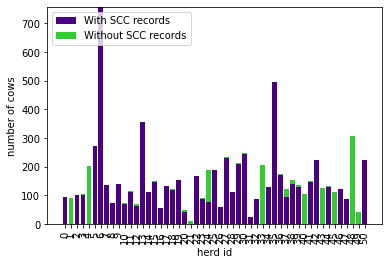

In [10]:
"""using function: herd_animal_scc"""
ls_num_animal, ls_nan_animal = herd_animal_scc(df)
"""using function: """
plot_herds_scc_nan(df, ls_num_animal, ls_nan_animal)

### Exlcude farms that without SCC records 

In [11]:
"""
args: 
    df: with hrd_ida 
    ls_num_animal: list[int]
    ls_nan_animal: list[int]
return: 
    df 
"""
def delete_non_scc_herds(df, ls_num_animal, ls_nan_animal):
    
    # herd id
    x = list(set(df['hrd_ida'].tolist()))
    
    # if ls_num_animal == ls_nan_animal, this herd has o scc record
    for i in range(len(x)): 
        if ls_num_animal[i] == ls_nan_animal[i]:
            # delete the herd from df 
            df = df.drop(df[df['hrd_ida'] == i].index, axis=0)
            
    return df

def delete_non_scc_animals(df):
    
    df = df[df['scc'].notna().groupby(df['anm_ida']).transform('any')]
    
    return df


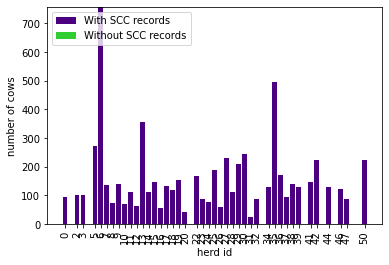

We have delete animals that have no SCC records


In [12]:
"""using function to delete herds"""
df = delete_non_scc_herds(df, ls_num_animal, ls_nan_animal)
"""using function to delete animals"""
df = delete_non_scc_animals(df)
# obtain the checking function again
ls_num_animal, ls_nan_animal = herd_animal_scc(df)
# to check if all the herds has scc
plot_herds_scc_nan(df, ls_num_animal, ls_nan_animal)
print("We have delete animals that have no SCC records")

In [13]:
# save df after cleaning nan scc 
df_clean_scc = df
print("We obtain the df with cleaned scc records (animal-wise): df_clean_scc")

We obtain the df with cleaned scc records (animal-wise): df_clean_scc


In [14]:
df_clean_scc.head()

,hrd_ida,anm_ida,milkng_date,anb_cd,lact_no,lact_start_date,lact_end_date,dim,birth_date,stall_no,milkng_code,mk_wgt,milkng_start_date,box_time,lr_milk_time,lf_milk_time,rf_milk_time,rr_milk_time,milk_time,prep_time,milk_flow_avg,milk_flow_max,ft_pcnt,pt_pcnt,scc,milkng_temp
0,30,6315,2022-01-01 07:20:23,HO,5.0,2020-08-26,2022-03-13,493.0,2013-05-11,102.0,0.0,11.2,2022-01-01 07:09:50,10.550000,5.150000,7.966667,3.700000,2.683333,7.966667,2.583333,1.4,3.7,5.417476,3.461845,NaN,38.9
1,30,6315,2022-01-01 20:16:46,HO,5.0,2020-08-26,2022-03-13,493.0,2013-05-11,103.0,0.0,13.0,2022-01-01 20:08:59,7.783333,3.466667,5.000000,3.066667,3.350000,5.000000,2.783333,2.6,4.4,3.427184,3.393883,NaN,38.8
2,30,6315,2022-01-02 10:06:59,HO,5.0,2020-08-26,2022-03-13,494.0,2013-05-11,103.0,0.0,10.6,2022-01-02 09:58:31,8.466667,4.133333,5.450000,2.983333,3.066667,5.450000,3.016667,1.9,3.5,4.718447,3.384175,112.0,38.3
3,30,6315,2022-01-02 21:47:54,HO,5.0,2020-08-26,2022-03-13,494.0,2013-05-11,103.0,0.0,10.1,2022-01-02 21:38:17,9.616667,2.850000,5.166667,2.316667,3.033333,5.166667,4.450000,2.0,4.0,5.601942,3.481262,NaN,38.1
4,30,6315,2022-01-03 12:21:50,HO,5.0,2020-08-26,2022-03-13,495.0,2013-05-11,103.0,0.0,11.2,2022-01-03 12:14:17,7.550000,3.566667,4.833333,3.233333,4.600000,4.833333,2.716667,2.3,3.6,5.427184,3.384175,NaN,38.1


# Checking abnormal vaule that equals zero: output df_clean_zero

In [15]:
"""
method: data_cleaning 

    clean and print the examples that were mis-recorded
args: 
    df: dataframe with columns: wk_wgt, milk_time...
return: 
    df: a cleaned dataframe 
"""
def data_cleaning(df):

    # initial samples
    samples = df.shape[0]
    print("number of samples before processing: \n", samples, "\n")
    
    df0 = df.loc[df['milkng_code'] == 0]
    print("discard examples by milkng_code=0: \n", df.shape[0] - df0.shape[0])

    df1 = df0.loc[df0['mk_wgt'] != 0]
    print("discard examples by mk_wgt=0: \n", df0.shape[0] - df1.shape[0])

    df2 = df1.loc[df1['milk_time'] != 0]
    print("discard examples by milk_time=0: \n", df1.shape[0] - df2.shape[0])

    df3 = df2.loc[df2['milk_flow_max'] != 0]
    print("discard examples by milk_flow_max=0: \n", df2.shape[0] - df3.shape[0])
    
    df4 = df3.loc[df3['milk_flow_avg'] != 0]
    print("discard examples by milk_flow_avg=0: \n", df3.shape[0] - df4.shape[0])

    df5 = df4.loc[(df4['lr_milk_time'] != 0) | (df4['lf_milk_time'] != 0) | (df4['rr_milk_time'] != 0) | (df4['rf_milk_time'] != 0)]
    print("discard examples by four milking time: \n", df4.shape[0] - df5.shape[0])
    
    print("\nnumber of samples after processing: \n", df5.shape[0], "\n")
    return df5

In [16]:
"""using function: data_"""
df_clean_zero = data_cleaning(df_clean_scc)
print("We obtain data with abnormal zeros cleaned: df_clean_zero")

number of samples before processing: 
 2653341 

discard examples by milkng_code=0: 
 51293
discard examples by mk_wgt=0: 
 630
discard examples by milk_time=0: 
 59
discard examples by milk_flow_max=0: 
 5
discard examples by milk_flow_avg=0: 
 33
discard examples by four milking time: 
 0

number of samples after processing: 
 2601321 

We obtain data with abnormal zeros cleaned: df_clean_zero


In [17]:
df_clean_zero.describe()

,hrd_ida,anm_ida,lact_no,dim,stall_no,milkng_code,mk_wgt,box_time,lr_milk_time,lf_milk_time,rf_milk_time,rr_milk_time,milk_time,prep_time,milk_flow_avg,milk_flow_max,ft_pcnt,pt_pcnt,scc,milkng_temp
count,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,2601321.0,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,942425.000000,2.601321e+06
mean,2.243071e+01,4.032877e+03,2.451419e+00,1.579822e+02,1.022217e+02,0.0,1.277352e+01,6.970670e+00,3.784095e+00,3.129945e+00,3.138477e+00,3.745242e+00,4.376627e+00,2.594044e+00,3.219002e+00,4.455466e+00,4.036831e+00,3.271076e+00,271.983768,3.870714e+01
std,1.361823e+01,2.319751e+03,1.501586e+00,1.178417e+02,1.850573e+00,0.0,3.922734e+00,2.069104e+00,1.820708e+00,1.545913e+00,1.536174e+00,1.819481e+00,1.907974e+00,7.826859e-01,1.110918e+00,1.395546e+00,9.964000e-01,4.208429e-01,533.679720,6.479622e-01
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.010000e+02,0.0,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.666667e-02,-8.433333e+00,1.000000e-01,2.000000e-01,0.000000e+00,0.000000e+00,1.000000,2.120000e+01
25%,9.000000e+00,2.065000e+03,1.000000e+00,6.800000e+01,1.010000e+02,0.0,1.010000e+01,5.550000e+00,2.583333e+00,2.133333e+00,2.133333e+00,2.550000e+00,3.050000e+00,2.200000e+00,2.400000e+00,3.500000e+00,3.504854e+00,3.141456e+00,39.000000,3.830000e+01
50%,2.500000e+01,4.021000e+03,2.000000e+00,1.410000e+02,1.020000e+02,0.0,1.220000e+01,6.550000e+00,3.450000e+00,2.850000e+00,2.850000e+00,3.416667e+00,3.966667e+00,2.433333e+00,3.100000e+00,4.300000e+00,4.038835e+00,3.296796e+00,75.000000,3.870000e+01
75%,3.200000e+01,6.040000e+03,3.000000e+00,2.260000e+02,1.030000e+02,0.0,1.480000e+01,7.916667e+00,4.633333e+00,3.833333e+00,3.850000e+00,4.583333e+00,5.250000e+00,2.800000e+00,3.900000e+00,5.300000e+00,4.592233e+00,3.442427e+00,198.000000,3.910000e+01
max,5.000000e+01,8.013000e+03,1.100000e+01,1.393000e+03,1.120000e+02,0.0,5.440000e+01,1.184000e+02,2.140000e+01,2.093333e+01,2.081667e+01,2.096667e+01,2.140000e+01,1.159333e+02,2.100000e+01,1.270000e+01,1.406796e+01,6.500680e+00,10552.000000,5.370000e+01


# Adding useful variables

In [18]:
""" 
method: 
    to add previous scc_history as a vairable
arg: 
    temp_df with columns: anm_ida and scc
return: 
    temp_df with columns: scc_history
"""
def add_scc_history(temp_df):

    # init list for scc_history
    scc_history = [0 for i in range(len(temp_df))] 
    has_scc = 0
    
    # build two lists: cow_id_ls with cow id and scc_ls with scc
    cow_id_ls = temp_df['anm_ida'].to_list()
    scc_ls = temp_df['scc'].to_list()
    
    # looping cow_id_ls
    for i in range(len(cow_id_ls)-1):
        
        # get temp scc
        temp_scc = scc_ls[i]
        # change has if meet high value
        if temp_scc > 2000: 
            has_scc = 1
        elif temp_scc > 3000:
            has_scc = 2
            
        # append to the scc_history 
        scc_history[i] = has_scc
        # if cow id change, reset has_scc 
        this_id = cow_id_ls[i]
        next_id = cow_id_ls[i+1]
        if next_id != i: 
            has_scc = 0

    # finish looping
    # handle the last element 
    scc_history[-1] = scc_history[-2]
    temp_df['scc_history'] = scc_history
    
    return temp_df

In [19]:
# ratio of fat/protein 
# ratio of max/min flow rate

# Environment: weather (cold or hot 0/1) 
# Cow info: 
    # DIM (3 stages), 
    # parity (0 or 2 or more), 
    # prior mastitis cases (have or not)
    
"""
method: 
    to create new variables 

arg: 
    df with columns: 
    ft_pcnt
    pt_pcnt
    milk_flow_max
    flow_min
"""
def add_cow_info(temp_df):

    # Cow info: 
    
    # DIM (3 stages), 
    temp_df.loc[temp_df['dim'] <= 100, 'lact_stage'] = 1
    temp_df.loc[temp_df['dim'] > 100, 'lact_stage'] = 2
    temp_df.loc[temp_df['dim'] > 200, 'lact_stage'] = 3
    
    # parity (0 or 2 or more), 
    temp_df.loc[temp_df['lact_no'] <= 2, 'parity'] = 1  
    temp_df.loc[temp_df['lact_no'] > 2, 'parity'] = 2  
    temp_df.loc[temp_df['lact_no'] > 5, 'parity'] = 3
    
    # scc_history
    """ ---------- calling add_scc_history ----------- """
    temp_df = add_scc_history(temp_df)
    
    return temp_df

In [20]:
print("Adding cow_info and obtaining no_visit")
df_add_cow_info = add_cow_info(df_clean_zero)

Adding cow_info and obtaining no_visit


In [21]:
print("As the variable milkng_date now have the time, we need to use milkng_date_time to represent date with time and milkng_date with only date: ")
import datetime as dt

# get the date in string
date_str = df_add_cow_info["milkng_date"].dt.strftime('%Y-%m-%d').tolist()
# set date time
df_add_cow_info["milkng_date_time"] = df_add_cow_info["milkng_date"]
# convert date string to date int 
date_int = [int(i[:4])*10000 + int(i[5:7])*100 + int(i[8:]) for i in date_str]
# set date only
df_add_cow_info["milkng_date"] = date_int
print("Done")

As the variable milkng_date now have the time, we need to use milkng_date_time to represent date with time and milkng_date with only date: 
Done


In [22]:
df_add_cow_info.head()

,hrd_ida,anm_ida,milkng_date,anb_cd,lact_no,lact_start_date,lact_end_date,dim,birth_date,stall_no,milkng_code,mk_wgt,milkng_start_date,box_time,lr_milk_time,lf_milk_time,rf_milk_time,rr_milk_time,milk_time,prep_time,milk_flow_avg,milk_flow_max,ft_pcnt,pt_pcnt,scc,milkng_temp,lact_stage,parity,scc_history,milkng_date_time
0,30,6315,20220101,HO,5.0,2020-08-26,2022-03-13,493.0,2013-05-11,102.0,0.0,11.2,2022-01-01 07:09:50,10.550000,5.150000,7.966667,3.700000,2.683333,7.966667,2.583333,1.4,3.7,5.417476,3.461845,NaN,38.9,3.0,2.0,0,2022-01-01 07:20:23
1,30,6315,20220101,HO,5.0,2020-08-26,2022-03-13,493.0,2013-05-11,103.0,0.0,13.0,2022-01-01 20:08:59,7.783333,3.466667,5.000000,3.066667,3.350000,5.000000,2.783333,2.6,4.4,3.427184,3.393883,NaN,38.8,3.0,2.0,0,2022-01-01 20:16:46
2,30,6315,20220102,HO,5.0,2020-08-26,2022-03-13,494.0,2013-05-11,103.0,0.0,10.6,2022-01-02 09:58:31,8.466667,4.133333,5.450000,2.983333,3.066667,5.450000,3.016667,1.9,3.5,4.718447,3.384175,112.0,38.3,3.0,2.0,0,2022-01-02 10:06:59
3,30,6315,20220102,HO,5.0,2020-08-26,2022-03-13,494.0,2013-05-11,103.0,0.0,10.1,2022-01-02 21:38:17,9.616667,2.850000,5.166667,2.316667,3.033333,5.166667,4.450000,2.0,4.0,5.601942,3.481262,NaN,38.1,3.0,2.0,0,2022-01-02 21:47:54
4,30,6315,20220103,HO,5.0,2020-08-26,2022-03-13,495.0,2013-05-11,103.0,0.0,11.2,2022-01-03 12:14:17,7.550000,3.566667,4.833333,3.233333,4.600000,4.833333,2.716667,2.3,3.6,5.427184,3.384175,NaN,38.1,3.0,2.0,0,2022-01-03 12:21:50


In [23]:
""" 
method: 
    1. first build min_milk_time, and var_milk_time 
    2. the groupby each variable: 
        adding: wk_wgt, 
        min: min_time
        max: var_time, milk_flow_max, scc
        ave: ft_pcnt, pt_pcnt, milkng_temp, dim, lact_no
     3. no_visit: using anm_ida + milkng_date
     4. cow_info: use anm_ida + milng_date + parity + dim + scc
     
arg: 
    df: dataframe with ... 
    
return:

"""
def add_variables(df): 
    
    # build min_time: min(lf, lr, rf, rr milk time) 
    min_time = df.loc[:,['lr_milk_time', 'lf_milk_time', 'rf_milk_time', 'rr_milk_time']].min(axis=1)
    # add into the column
    df['min_time'] = min_time

    # get vars by rows from four selected columns
    var_time = df.loc[:,['lr_milk_time', 'lf_milk_time', 'rf_milk_time', 'rr_milk_time']].var(axis=1)
    # append to the df dataset 
    df['var_time'] = var_time

    # create a new variable that is unique for each cow and each day: anm_ida + milkng_date
    df['anm_ida_milkng_date'] = df['anm_ida'].apply(lambda x: str(x) + "-") + df['milkng_date'].apply(lambda x: str(x))

    return df

In [24]:
"""using func: """
df_add_variables = add_variables(df_add_cow_info)

In [25]:
df_add_variables.head()

,hrd_ida,anm_ida,milkng_date,anb_cd,lact_no,lact_start_date,lact_end_date,dim,birth_date,stall_no,milkng_code,mk_wgt,milkng_start_date,box_time,lr_milk_time,lf_milk_time,rf_milk_time,rr_milk_time,milk_time,prep_time,milk_flow_avg,milk_flow_max,ft_pcnt,pt_pcnt,scc,milkng_temp,lact_stage,parity,scc_history,milkng_date_time,min_time,var_time,anm_ida_milkng_date
0,30,6315,20220101,HO,5.0,2020-08-26,2022-03-13,493.0,2013-05-11,102.0,0.0,11.2,2022-01-01 07:09:50,10.550000,5.150000,7.966667,3.700000,2.683333,7.966667,2.583333,1.4,3.7,5.417476,3.461845,NaN,38.9,3.0,2.0,0,2022-01-01 07:20:23,2.683333,5.272685,6315-20220101
1,30,6315,20220101,HO,5.0,2020-08-26,2022-03-13,493.0,2013-05-11,103.0,0.0,13.0,2022-01-01 20:08:59,7.783333,3.466667,5.000000,3.066667,3.350000,5.000000,2.783333,2.6,4.4,3.427184,3.393883,NaN,38.8,3.0,2.0,0,2022-01-01 20:16:46,3.066667,0.755440,6315-20220101
2,30,6315,20220102,HO,5.0,2020-08-26,2022-03-13,494.0,2013-05-11,103.0,0.0,10.6,2022-01-02 09:58:31,8.466667,4.133333,5.450000,2.983333,3.066667,5.450000,3.016667,1.9,3.5,4.718447,3.384175,112.0,38.3,3.0,2.0,0,2022-01-02 10:06:59,2.983333,1.330463,6315-20220102
3,30,6315,20220102,HO,5.0,2020-08-26,2022-03-13,494.0,2013-05-11,103.0,0.0,10.1,2022-01-02 21:38:17,9.616667,2.850000,5.166667,2.316667,3.033333,5.166667,4.450000,2.0,4.0,5.601942,3.481262,NaN,38.1,3.0,2.0,0,2022-01-02 21:47:54,2.316667,1.572685,6315-20220102
4,30,6315,20220103,HO,5.0,2020-08-26,2022-03-13,495.0,2013-05-11,103.0,0.0,11.2,2022-01-03 12:14:17,7.550000,3.566667,4.833333,3.233333,4.600000,4.833333,2.716667,2.3,3.6,5.427184,3.384175,NaN,38.1,3.0,2.0,0,2022-01-03 12:21:50,3.233333,0.605463,6315-20220103


In [26]:
""" 
func: 
    add no_visit base on anm_ida_milkng_date
args: 
    df: panda df 
return: 
    df_no_visit: df with no_visit
"""
def add_no_visit(id_date_ls): 
    

    # init no_visit
    no_visit = [] 
    # init count
    count = 1
    # loop 
    for i in range(len(id_date_ls)-1): 

        # if the same
        if id_date_ls[i] == id_date_ls[i+1]: 
            count += 1 

        # if meets the end
        if i+2 == len(id_date_ls): 
            # add to no_visit 
            no_visit += [count] * count
            # reset count 
            count = 1

        # if meets the different element 
        elif id_date_ls[i] != id_date_ls[i+1]: 
            # add to no_visit 
            no_visit += [count] * count
            # reset count 
            count = 1
        else: 
            pass

    # handle the last one: assume len(id_date_ls) has many dates > 3
    if id_date_ls[-1] != id_date_ls[-2]: 
        no_visit.append(1)

    # log transform scc
    #print("log 10 transform scc")
    #df['scc'] = np.log10(df['scc'])
    
    return no_visit

In [27]:


# obtain the list of anm_ida_milkng_date 
id_date_ls = df_add_variables['anm_ida_milkng_date'].tolist()
"""using func: """
no_visit = add_no_visit(id_date_ls)
# add no_visit to df and return 
df_add_variables['no_visit'] = no_visit
# also rename the dataset 
df_no_visit = df_add_variables

In [28]:
df_add_variables[:10]

,hrd_ida,anm_ida,milkng_date,anb_cd,lact_no,lact_start_date,lact_end_date,dim,birth_date,stall_no,milkng_code,mk_wgt,milkng_start_date,box_time,lr_milk_time,lf_milk_time,rf_milk_time,rr_milk_time,milk_time,prep_time,milk_flow_avg,milk_flow_max,ft_pcnt,pt_pcnt,scc,milkng_temp,lact_stage,parity,scc_history,milkng_date_time,min_time,var_time,anm_ida_milkng_date,no_visit
0,30,6315,20220101,HO,5.0,2020-08-26,2022-03-13,493.0,2013-05-11,102.0,0.0,11.2,2022-01-01 07:09:50,10.550000,5.150000,7.966667,3.700000,2.683333,7.966667,2.583333,1.4,3.7,5.417476,3.461845,NaN,38.9,3.0,2.0,0,2022-01-01 07:20:23,2.683333,5.272685,6315-20220101,2
1,30,6315,20220101,HO,5.0,2020-08-26,2022-03-13,493.0,2013-05-11,103.0,0.0,13.0,2022-01-01 20:08:59,7.783333,3.466667,5.000000,3.066667,3.350000,5.000000,2.783333,2.6,4.4,3.427184,3.393883,NaN,38.8,3.0,2.0,0,2022-01-01 20:16:46,3.066667,0.755440,6315-20220101,2
2,30,6315,20220102,HO,5.0,2020-08-26,2022-03-13,494.0,2013-05-11,103.0,0.0,10.6,2022-01-02 09:58:31,8.466667,4.133333,5.450000,2.983333,3.066667,5.450000,3.016667,1.9,3.5,4.718447,3.384175,112.0,38.3,3.0,2.0,0,2022-01-02 10:06:59,2.983333,1.330463,6315-20220102,2
3,30,6315,20220102,HO,5.0,2020-08-26,2022-03-13,494.0,2013-05-11,103.0,0.0,10.1,2022-01-02 21:38:17,9.616667,2.850000,5.166667,2.316667,3.033333,5.166667,4.450000,2.0,4.0,5.601942,3.481262,NaN,38.1,3.0,2.0,0,2022-01-02 21:47:54,2.316667,1.572685,6315-20220102,2
4,30,6315,20220103,HO,5.0,2020-08-26,2022-03-13,495.0,2013-05-11,103.0,0.0,11.2,2022-01-03 12:14:17,7.550000,3.566667,4.833333,3.233333,4.600000,4.833333,2.716667,2.3,3.6,5.427184,3.384175,NaN,38.1,3.0,2.0,0,2022-01-03 12:21:50,3.233333,0.605463,6315-20220103,2
5,30,6315,20220103,HO,5.0,2020-08-26,2022-03-13,495.0,2013-05-11,103.0,0.0,6.1,2022-01-03 20:24:25,8.683333,2.966667,5.116667,2.450000,2.166667,5.116667,3.566667,1.2,2.7,4.796117,3.393883,104.0,38.0,3.0,2.0,0,2022-01-03 20:33:06,2.166667,1.785278,6315-20220103,2
6,30,6315,20220104,HO,5.0,2020-08-26,2022-03-13,496.0,2013-05-11,103.0,0.0,11.3,2022-01-04 11:54:19,9.050000,3.433333,5.550000,2.633333,2.666667,5.550000,3.500000,2.0,4.0,4.699029,3.316214,NaN,38.4,3.0,2.0,0,2022-01-04 12:03:22,2.633333,1.877477,6315-20220104,2
7,30,6315,20220104,HO,5.0,2020-08-26,2022-03-13,496.0,2013-05-11,101.0,0.0,7.3,2022-01-04 19:26:43,9.283333,3.200000,4.583333,2.100000,2.950000,4.583333,4.700000,1.6,3.0,6.368932,3.306505,NaN,37.7,3.0,2.0,0,2022-01-04 19:36:00,2.100000,1.061944,6315-20220104,2
8,30,6315,20220105,HO,5.0,2020-08-26,2022-03-13,497.0,2013-05-11,102.0,0.0,9.7,2022-01-05 06:47:54,8.516667,4.683333,5.966667,2.833333,2.733333,5.966667,2.550000,1.6,3.4,4.553398,3.374466,81.0,38.8,3.0,2.0,0,2022-01-05 06:56:25,2.733333,2.429514,6315-20220105,2
9,30,6315,20220105,HO,5.0,2020-08-26,2022-03-13,497.0,2013-05-11,102.0,0.0,11.7,2022-01-05 19:36:24,9.166667,3.483333,4.966667,2.633333,3.350000,4.966667,4.200000,2.4,3.9,4.893204,3.403592,NaN,39.4,3.0,2.0,0,2022-01-05 19:45:34,2.633333,0.959352,6315-20220105,2


# Descriptive statistics per herd or per robot

In [29]:
""" 
Goal: 
    given a dataset (for a herd or for a robot) and a list of variable names,
    plot the box plot for each variable, 
    or just display the information
"""
print("\n")

In [30]:
print("print the herd idx and stall idx on each herd")

herd_idx_ls = df_no_visit['hrd_ida'].unique().tolist()
#print("herd_idx_ls: ", herd_idx_ls)

# print stall id for each herd 
for herd_idx in herd_idx_ls: 
    df_temp = df_no_visit[df_no_visit['hrd_ida'] == herd_idx]
    stall_idx_ls = df_temp['stall_no'].unique().tolist()
    #print("stall_idx_ls: ", stall_idx_ls)

print the herd idx and stall idx on each herd


In [31]:
import matplotlib.pyplot as plt

""" 
func: 
    plot the box plot and return a list of mean and std
"""
def box_mean_var(df, var_ls): 
    
    # init 
    mean_ls = [] 
    std_ls = []
    
    for i in range(len(var_ls)): 
        # box plot
        boxplot = df.boxplot(by='hrd_ida', column=var_ls[i], rot=45, showfliers=False) 
        plt.show()
        
        # mean and std 
        mean_ls.append(np.mean(df[var_ls[i]]))
        std_ls.append(np.sqrt(np.var(df[var_ls[i]]))) 
        
    return mean_ls, std_ls

start visulize for different herds: 


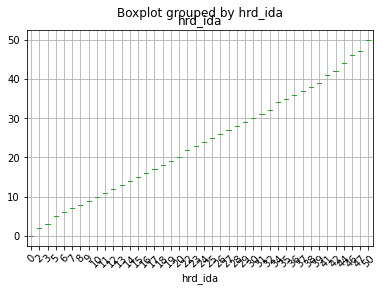

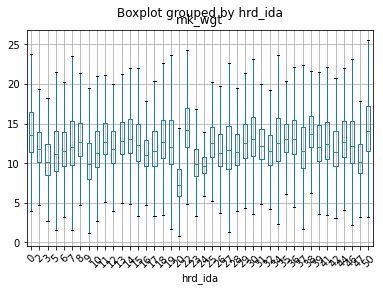

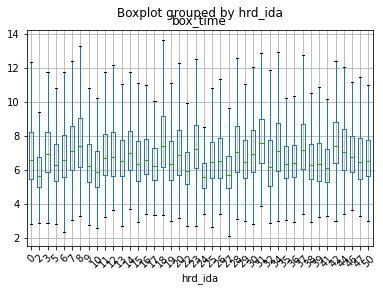

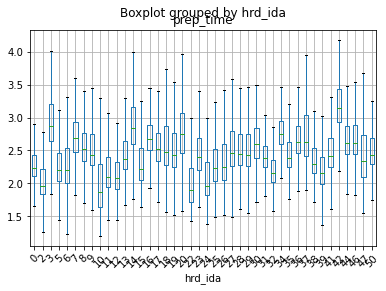

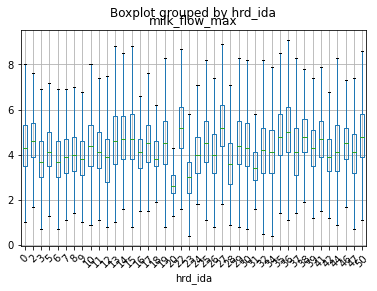

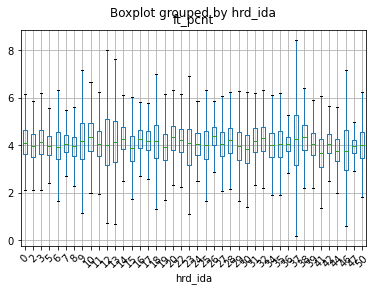

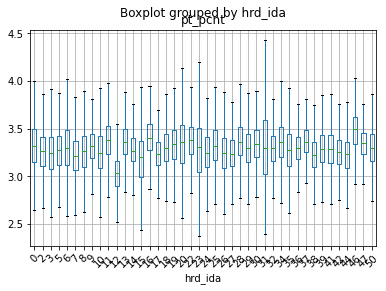

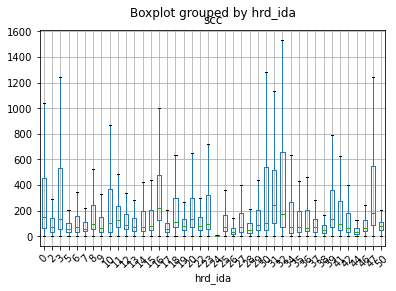

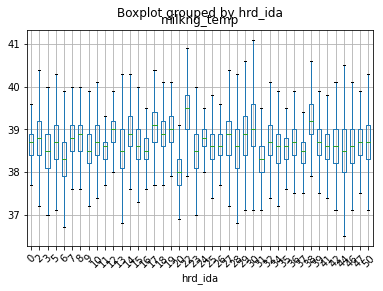

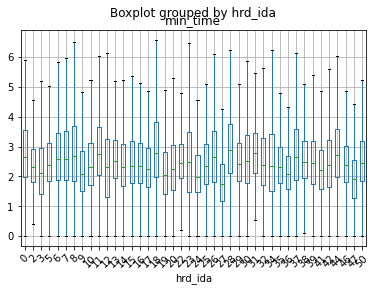

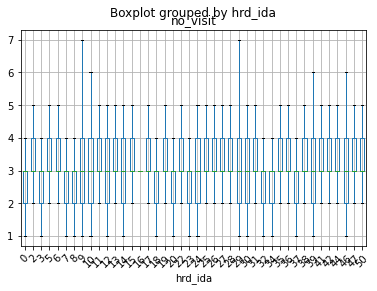

In [32]:
print("start visulize for different herds: ")

var_ls = ['hrd_ida', 'mk_wgt', 'box_time', 'prep_time', 'milk_flow_max', 'ft_pcnt', 'pt_pcnt', 'scc', 'milkng_temp','min_time', 'no_visit']

"""using func: """
mean_ls, std_ls = box_mean_var(df_no_visit, var_ls)

inspect linear correlation... 


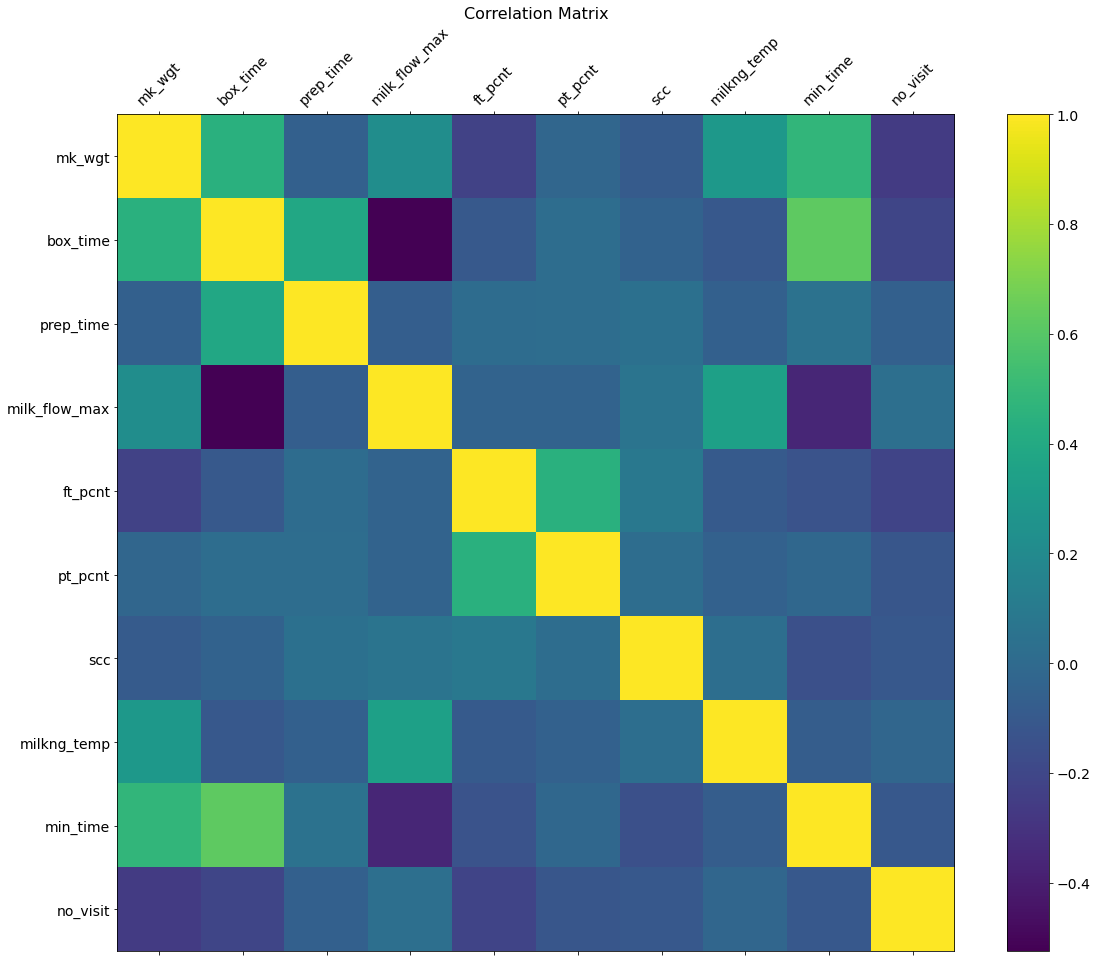

In [33]:
print("inspect linear correlation... ")
#df = df_no_visit[df_no_visit['hrd_ida']==18]
df = df_no_visit
var_ls = ['mk_wgt', 'box_time', 'prep_time', 'milk_flow_max', 'ft_pcnt', 'pt_pcnt', 'scc', 'milkng_temp','min_time', 'no_visit']
df = df[var_ls]
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

# Spikes: Input (df_no_visit)

### Categoriza one cow based on dynamic mean and std

In [118]:
""" 
func: 
    cat ls by mean and std
args: 
    ls: list[float]
    mean, std: float 
    step: int (steps of std)
return
    cat_ls: list[float]
"""
def cat_mean_std(ls, mean, std, step=2): 
    #print("ls, mean, std: ", ls, mean, std)
    for i in range(len(ls)): 
        if (ls[i] > mean+2*step*std) or (ls[i] < mean-2*step*std): 
            ls[i] = 2 
        elif (ls[i] > mean+step*std) or (ls[i] < mean-step*std): 
            ls[i] = 1 
        else: 
            ls[i] = 0
    return ls

""" 
func: 
    cat one cow 
args: 
    df_cow: df 
    var_ls: list[str] 
    var_cat_ls: list[str]
    INTERVAL: int
return: 
    new_df_cow
"""
def cat_one_cow(df_cow, var_ls, var_cat_ls, INTERVAL):
    
    # build dictionary
    mean_dict = {}
    std_dict = {}
    # loop for init dictionary
    for (var_name) in var_ls:
        # init mean_dict
        mean_dict[var_name] = np.mean(df_cow[var_name])
        # init std_dict
        std_dict[var_name] = np.sqrt(np.var(df_cow[var_name]))

    # init new_df_cow 
    new_df_cow = pd.DataFrame()

    # for every 21 milking visits (about 7 to 10 days), update the dictionary
    interval = INTERVAL
    # should be at least 'interval' milking visits 
    if df_cow.shape[0] > interval: 

        # looping for var 
        for var_name in var_ls: 
            # init a list to store a col
            one_col = []

            # loop 
            for row_idx in range(interval, df_cow.shape[0], interval):

                # list from df_cow['mk_wgt'][row_idx-interval:row_idx]
                col_ls = df_cow[var_name][row_idx-interval:row_idx].tolist()
                # print("col_ls: ", col_ls)

                # assign categorical variable
                mean, std = mean_dict[var_name], std_dict[var_name]    
                """using func: """
                cat_ls = cat_mean_std(col_ls, mean, std)
                # append to one col 
                one_col += cat_ls

                # update mean_dict
                mean_dict[var_name] = np.mean(df_cow[var_name][row_idx-interval:row_idx])

                # update std_dict
                std_dict[var_name] = np.sqrt(np.var(df_cow[var_name][row_idx-interval:row_idx]))

            # for the last interval (len < INTERVAL)
            col_ls = df_cow[var_name][row_idx:].tolist()
            # assign categorical variable
            mean, std = mean_dict[var_name], std_dict[var_name]    
            """using func: """
            cat_ls = cat_mean_std(col_ls, mean, std)
            # append to one col 
            one_col += cat_ls
            
            # complete on col 
            cat_name = var_name + "_cat"
            new_df_cow[cat_name] = one_col

    else: 
        pass
    
    # lastly, append dim, parity, and scc
    for name in var_cat_ls: 
        new_df_cow[name] = df_cow[name].tolist()

    # print("new_df_cow: ", new_df_cow.shape)
    return new_df_cow


### Categorize herds

In [119]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

""" 
func: 
    categroize herd 
args: 
    df_ex: 
    params from used functions: cat_one_cow
return: 
    df_cat
"""
print("first handle dim, parity, and scc, as their categorization is static...")
print("categorization for better visualization")
print("scc: 0 (<400 or nan), 1 (400 to 2000), 2 (>2000)")
print("var_ls: 0 (within +- 1std), 1 (1std to 2std), 2 (> 2std)")
print("dim 0 (<100), 1 (100 to 300), 2 (>300)")
print("parity 0 (1), 1 (2 to 4), 2 (>5)")

def cat_herd(df_ex, var_ls, var_cat_ls, INTERVAL):
    
    # create unique id for each animal 
    df_ex['cow_herd_id'] = df_ex["anm_ida"] * 100 + df_ex["hrd_ida"] 
    
    # handle dim, parity, and scc
    df_ex['dim_cat'] = 0
    df_ex.loc[df_ex['dim'] > 100, 'dim_cat'] = 1
    df_ex.loc[df_ex['dim'] > 300, 'dim_cat'] = 2

    df_ex['parity_cat'] = 0
    df_ex.loc[df_ex['parity'] > 1, 'parity_cat'] = 1
    df_ex.loc[df_ex['parity'] > 4, 'parity_cat'] = 2

    df_ex['scc_cat'] = 0
    df_ex.loc[df_ex['scc'] > 400, 'scc_cat'] = 1
    df_ex.loc[df_ex['scc'] > 2000, 'scc_cat'] = 2

    # create list of all cows
    cow_herd_id_ls = df_ex['cow_herd_id'].unique().tolist()

    # init ls to store cat df cow 
    ls_cat_df_cow = [] 
    # loop idx of cow
    for idx in cow_herd_id_ls: 
        # get cow by idx
        df_cow = df_ex[df_ex['cow_herd_id']==idx] 
        """using func: """
        df_cow_cat = cat_one_cow(df_cow, var_ls, var_cat_ls, INTERVAL)
        # append to ls
        ls_cat_df_cow.append(df_cow_cat)

    # concat 
    df_cat = pd.concat(ls_cat_df_cow)
    return df_cat

first handle dim, parity, and scc, as their categorization is static...
categorization for better visualization
scc: 0 (<400 or nan), 1 (400 to 2000), 2 (>2000)
var_ls: 0 (within +- 1std), 1 (1std to 2std), 2 (> 2std)
dim 0 (<100), 1 (100 to 300), 2 (>300)
parity 0 (1), 1 (2 to 4), 2 (>5)


### Apply categorization function

In [122]:
herd_idx_ls = df_no_visit['hrd_ida'].unique().tolist() 
herd_idx = herd_idx_ls[0]
df_herd = df_no_visit[df_no_visit['hrd_ida']==herd_idx]
print("pick one of the herd by a random index: ", herd_idx)
print()
# set variable list
var_ls = ['mk_wgt', 'box_time', 'prep_time', 'milk_flow_max', 'ft_pcnt', 'pt_pcnt', 'milkng_temp','min_time']
var_cat_ls = ['dim_cat', 'parity_cat', 'scc_cat', 'cow_herd_id']
print("set variable list: ", var_ls, var_cat_ls)

"""using func: """
df_cat = cat_herd(df_herd, var_ls, var_cat_ls, INTERVAL=60)
print("done! obtain df_cat")
df_cat.head()

pick one of the herd by a random index:  30
set variable list:  ['mk_wgt', 'box_time', 'prep_time', 'milk_flow_max', 'ft_pcnt', 'pt_pcnt', 'milkng_temp', 'min_time'] ['dim_cat', 'parity_cat', 'scc_cat', 'cow_herd_id']
done! obtain df_cat


,mk_wgt_cat,box_time_cat,prep_time_cat,milk_flow_max_cat,ft_pcnt_cat,pt_pcnt_cat,milkng_temp_cat,min_time_cat,dim_cat,parity_cat,scc_cat,cow_herd_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,0,631530
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,1,0,631530
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,0,631530
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,0,631530
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,0,631530


# Visualization after dynamic categorization

In [126]:
""" 
func: 
    plot one line in white red, and black 
args: 
    col1: list[0, 1, 2]
    base: int 
return: 
    plot a single line
"""

def one_line(col1, base):
    
    # adjust the baseline 
    col1 = [i+base for i in col1]
    # loop to print 
    for i in range(1, len(col1)): 
        if col1[i] == base + 1: 
            plt.plot([i-1, i], [base, base], color='black')
            #plt.show()
        elif col1[i] == base + 2: 
            plt.plot([i-1, i], [base, base], color='red')
            #plt.show()
        else: 
            plt.plot([i-1, i], [base, base], color='white')
            #plt.show()
        

<Figure size 4000x2000 with 0 Axes>

pick a random cow example:  631530
labels:  Index(['mk_wgt_cat', 'box_time_cat', 'prep_time_cat', 'milk_flow_max_cat', 'ft_pcnt_cat', 'pt_pcnt_cat', 'milkng_temp_cat', 'min_time_cat', 'dim_cat', 'parity_cat', 'scc_cat'], dtype='object')
confirm labels:  ['milk weight', 'box time', 'preparation time', 'milk flow max', 'fat%', 'protein%', 'milk temperature', 'milking time min', 'dim', 'parity', 'scc']


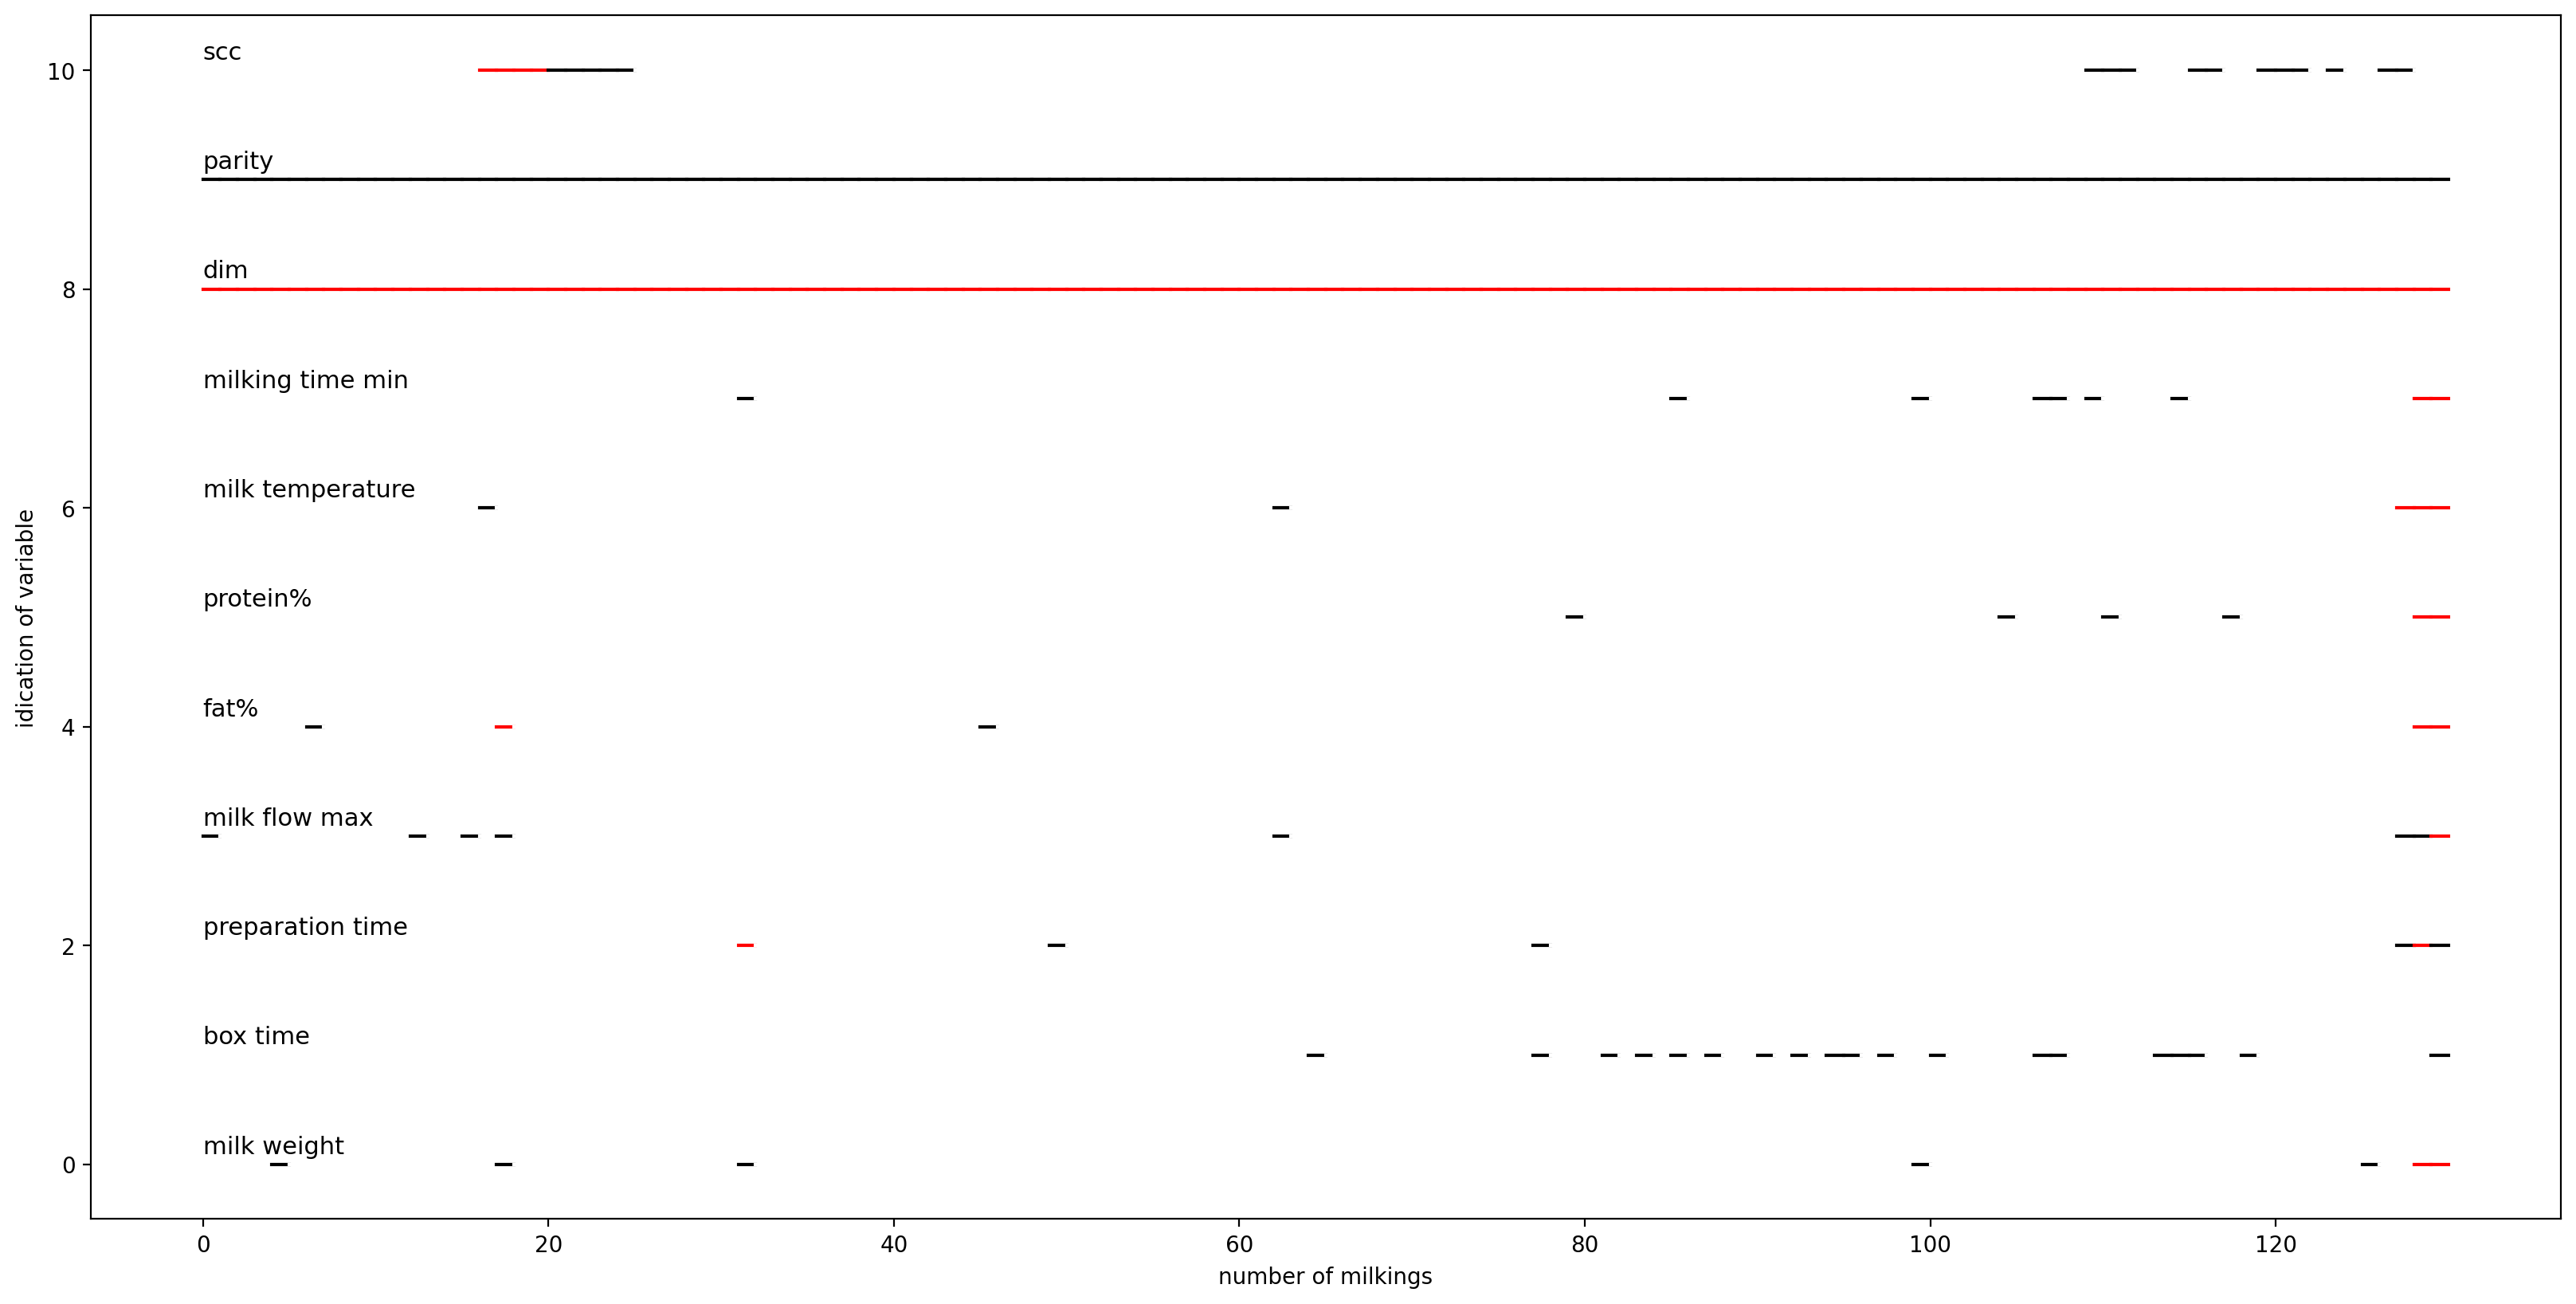

pick a random cow example:  93030
labels:  Index(['mk_wgt_cat', 'box_time_cat', 'prep_time_cat', 'milk_flow_max_cat', 'ft_pcnt_cat', 'pt_pcnt_cat', 'milkng_temp_cat', 'min_time_cat', 'dim_cat', 'parity_cat', 'scc_cat'], dtype='object')
confirm labels:  ['milk weight', 'box time', 'preparation time', 'milk flow max', 'fat%', 'protein%', 'milk temperature', 'milking time min', 'dim', 'parity', 'scc']


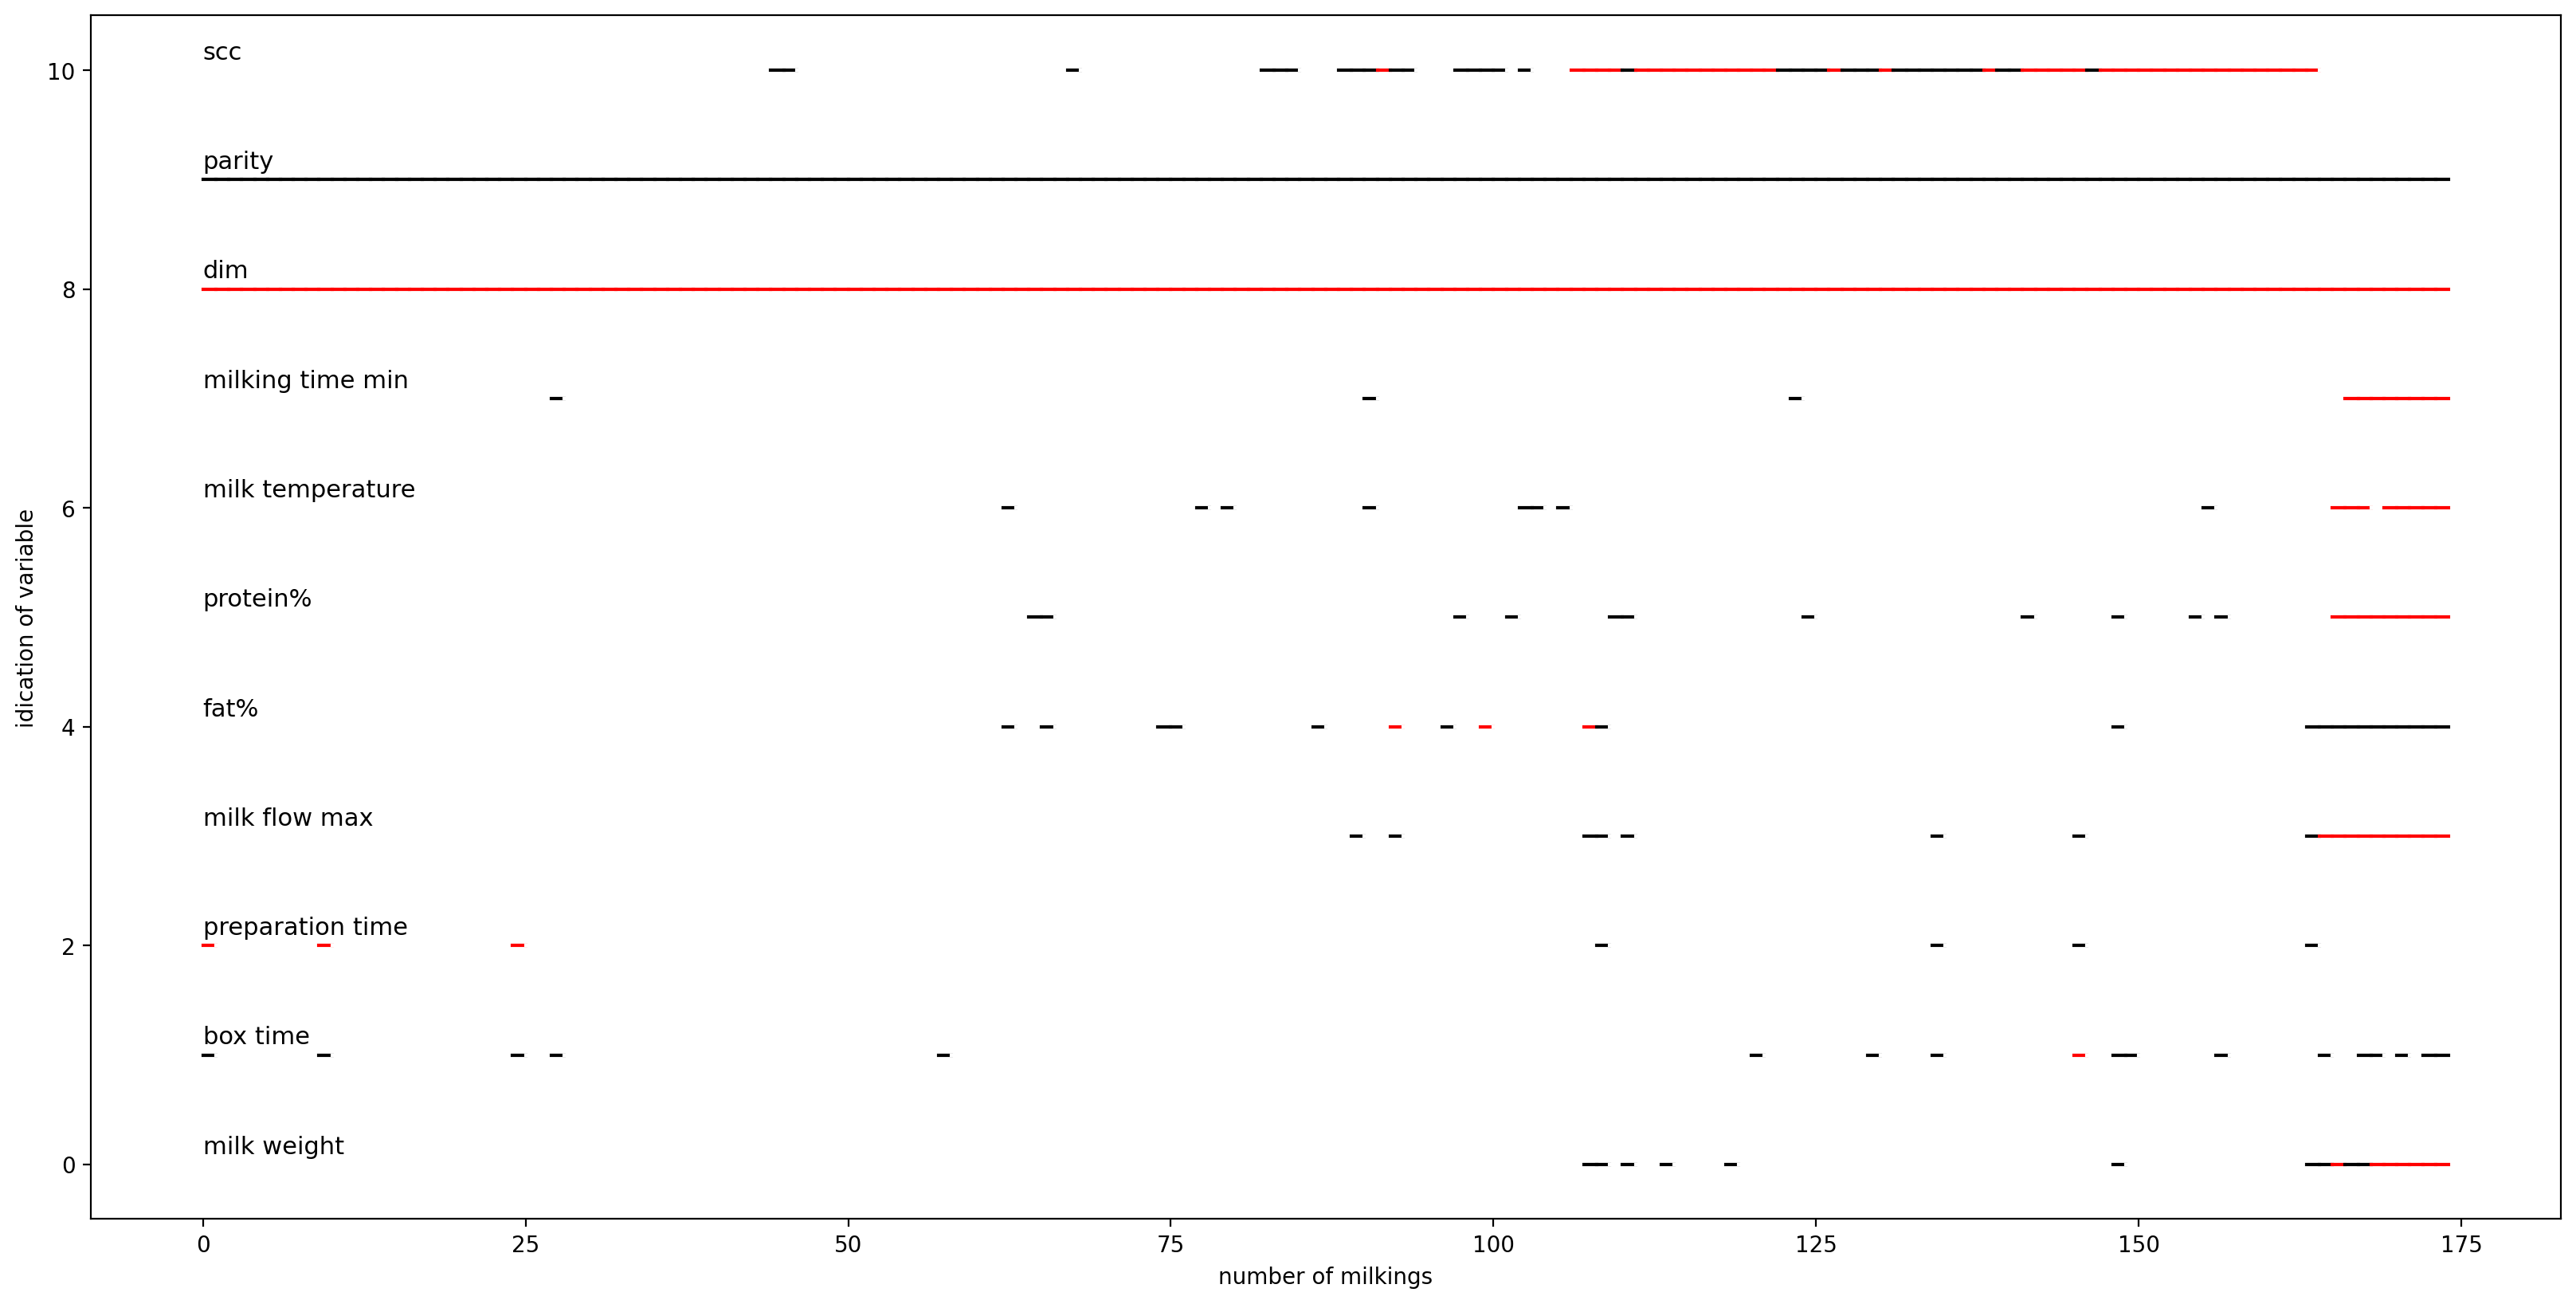

pick a random cow example:  659930
labels:  Index(['mk_wgt_cat', 'box_time_cat', 'prep_time_cat', 'milk_flow_max_cat', 'ft_pcnt_cat', 'pt_pcnt_cat', 'milkng_temp_cat', 'min_time_cat', 'dim_cat', 'parity_cat', 'scc_cat'], dtype='object')
confirm labels:  ['milk weight', 'box time', 'preparation time', 'milk flow max', 'fat%', 'protein%', 'milk temperature', 'milking time min', 'dim', 'parity', 'scc']


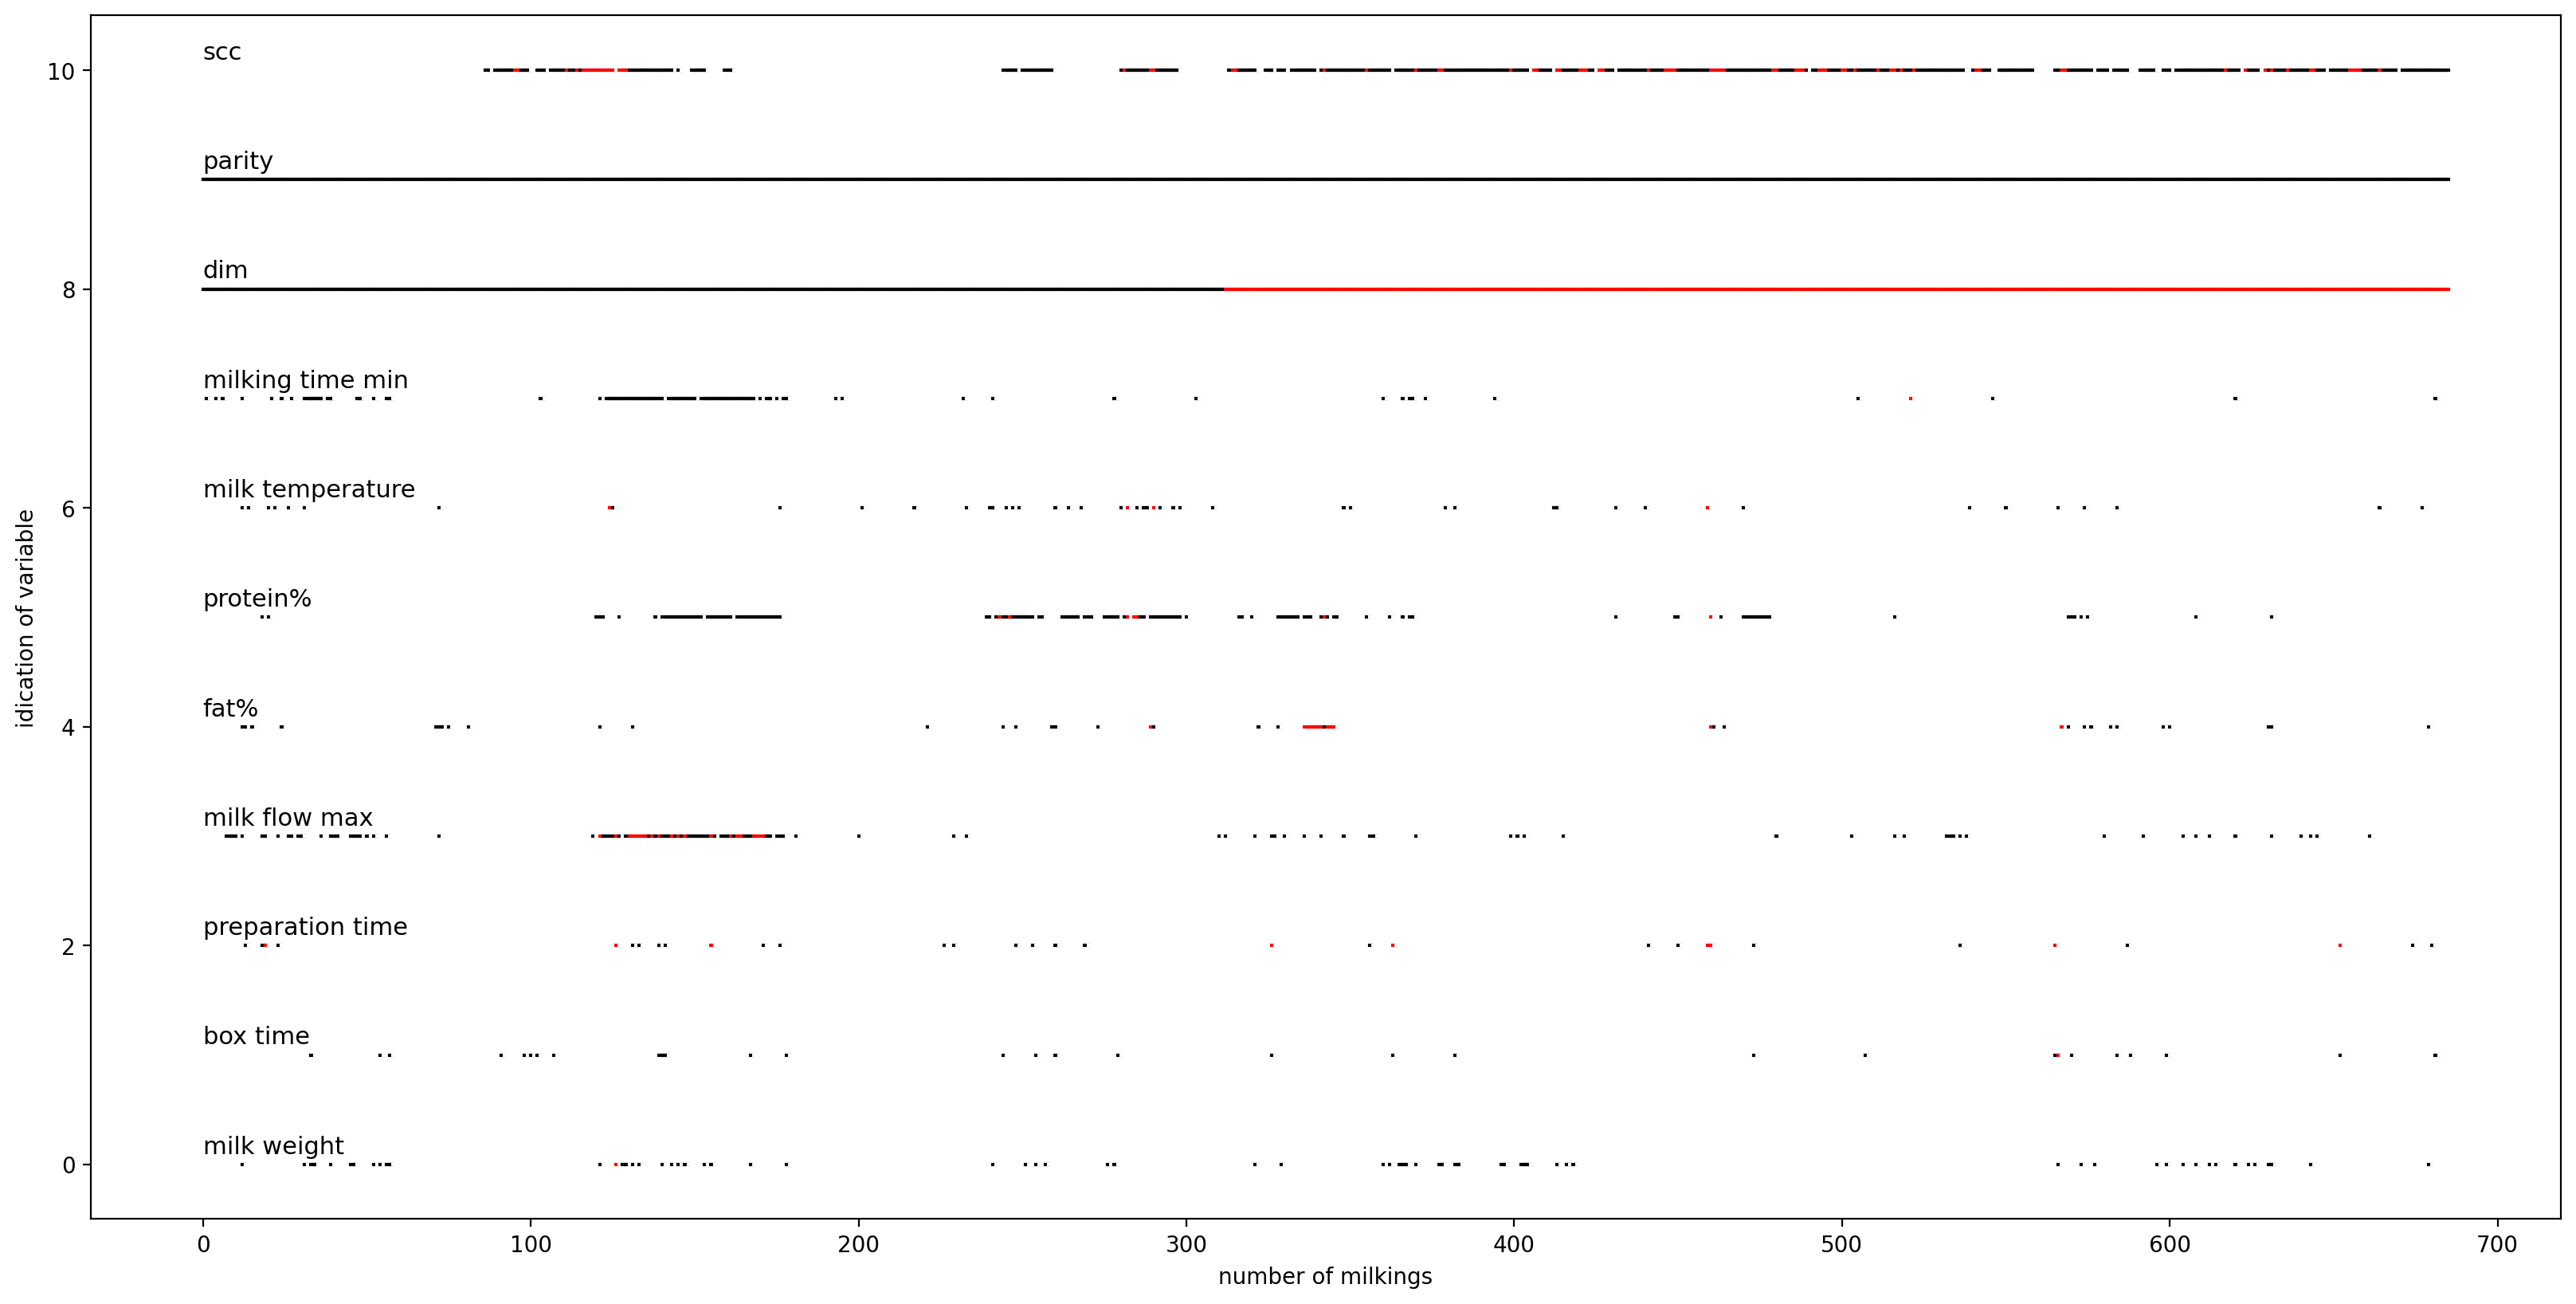

pick a random cow example:  738330
labels:  Index(['mk_wgt_cat', 'box_time_cat', 'prep_time_cat', 'milk_flow_max_cat', 'ft_pcnt_cat', 'pt_pcnt_cat', 'milkng_temp_cat', 'min_time_cat', 'dim_cat', 'parity_cat', 'scc_cat'], dtype='object')
confirm labels:  ['milk weight', 'box time', 'preparation time', 'milk flow max', 'fat%', 'protein%', 'milk temperature', 'milking time min', 'dim', 'parity', 'scc']


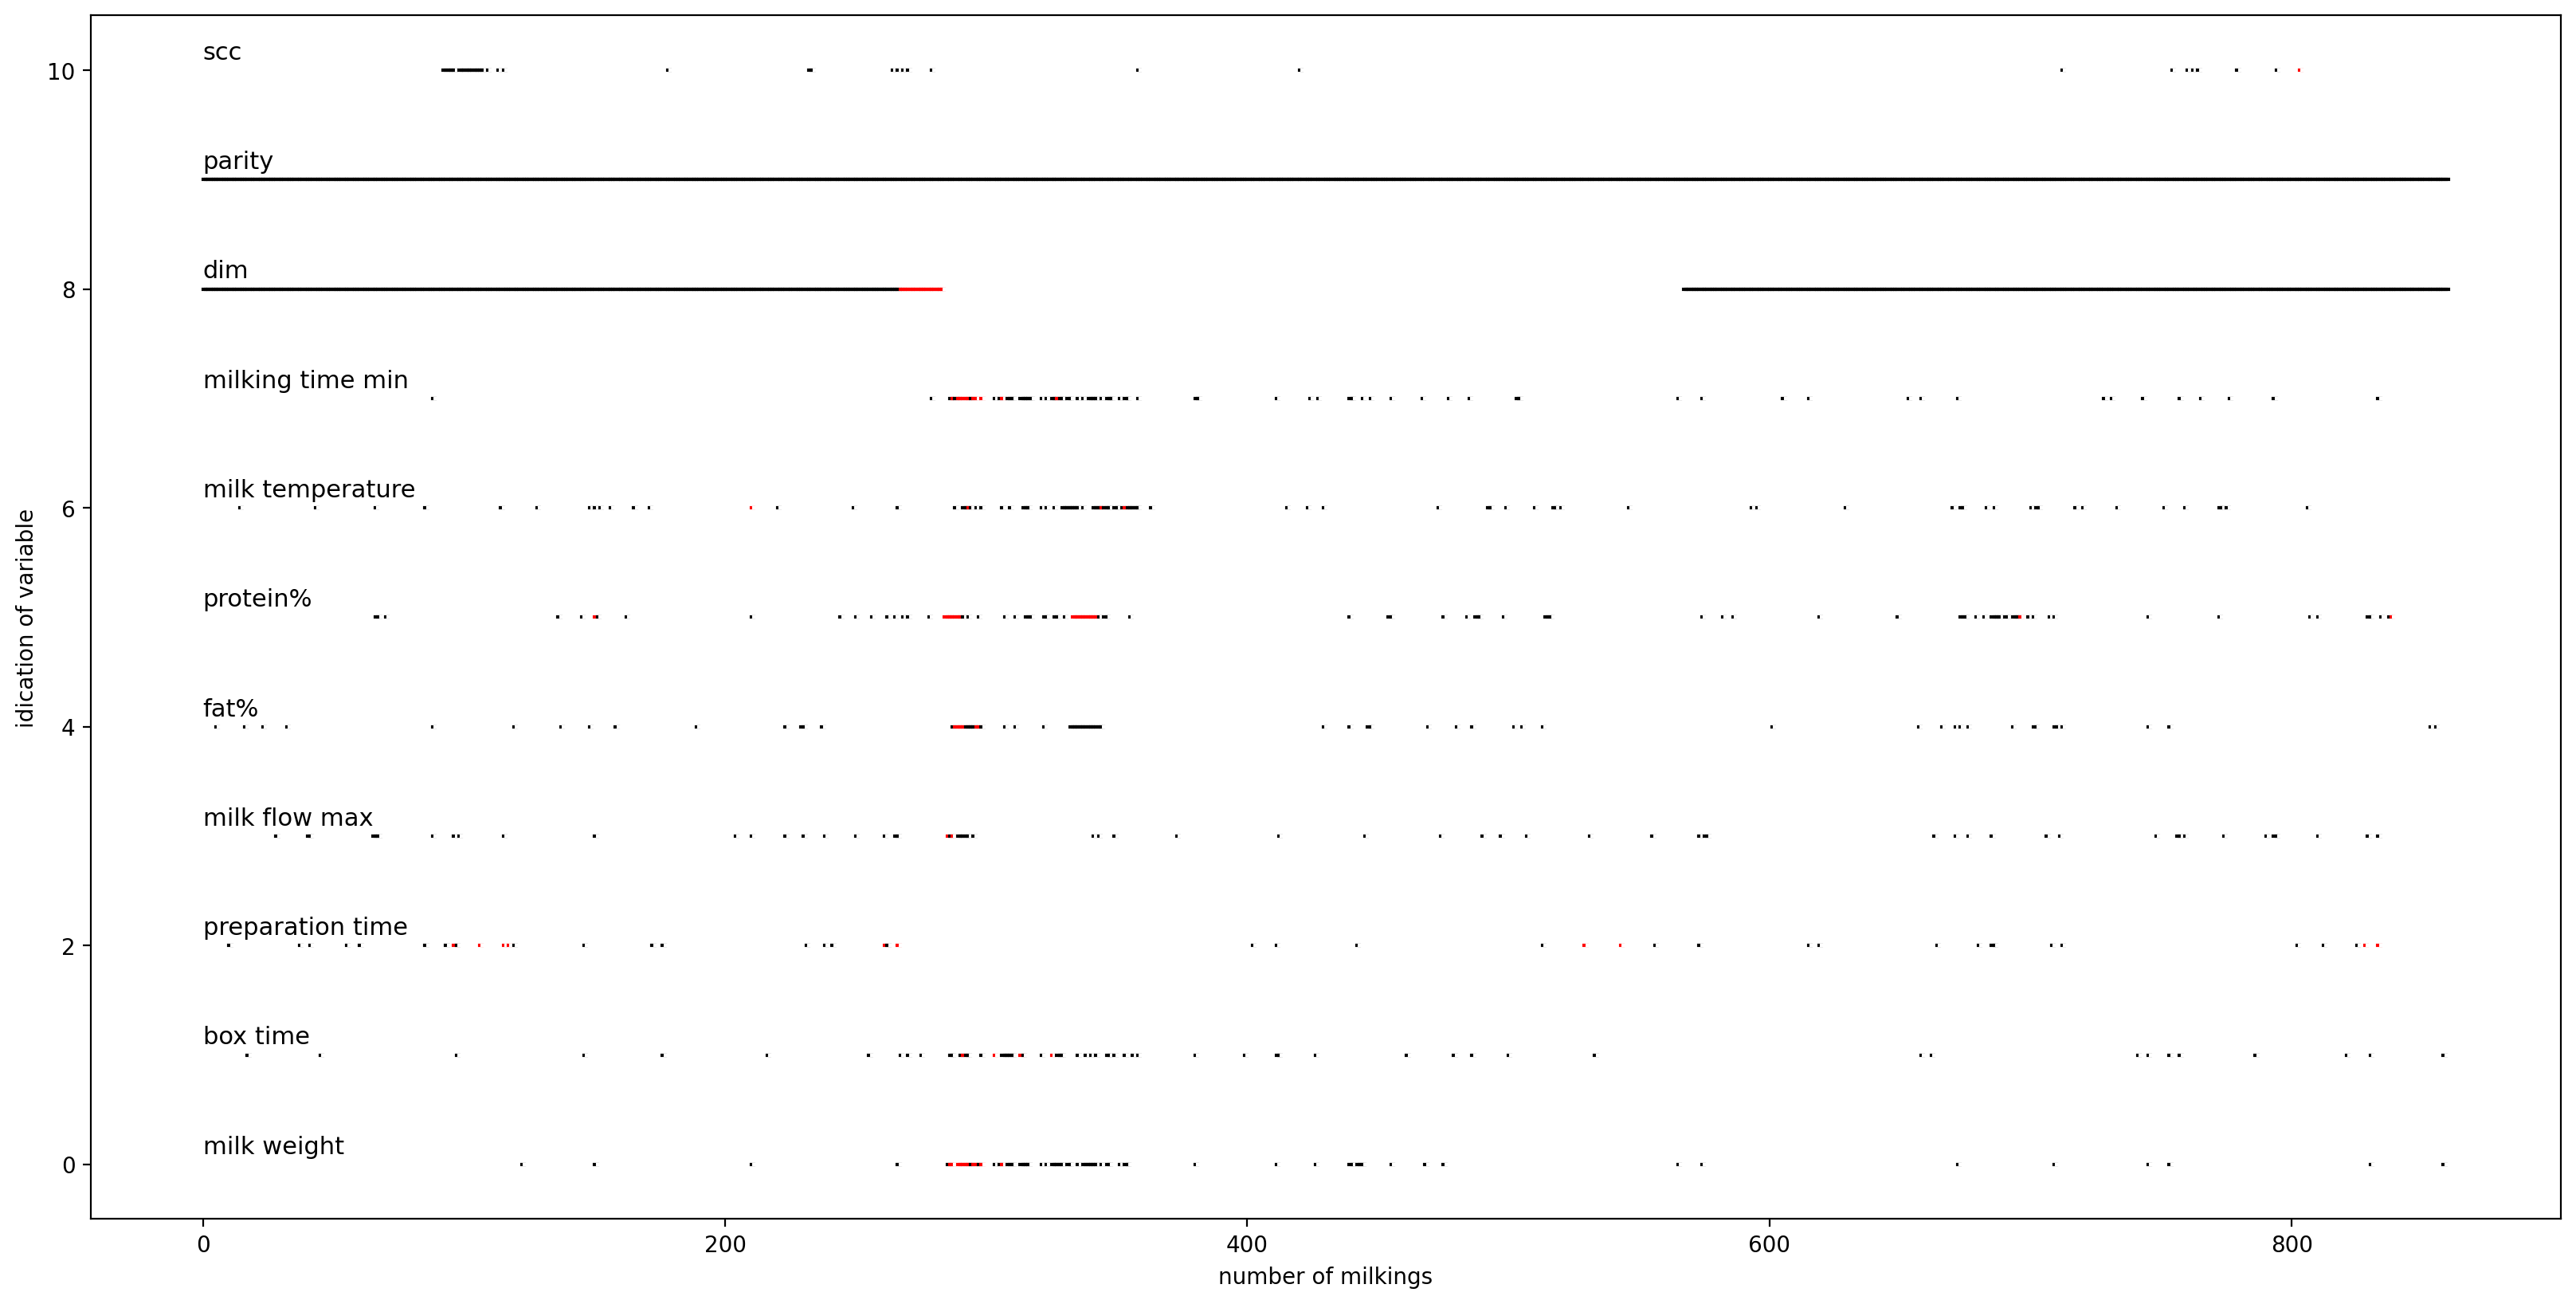

pick a random cow example:  151630
labels:  Index(['mk_wgt_cat', 'box_time_cat', 'prep_time_cat', 'milk_flow_max_cat', 'ft_pcnt_cat', 'pt_pcnt_cat', 'milkng_temp_cat', 'min_time_cat', 'dim_cat', 'parity_cat', 'scc_cat'], dtype='object')
confirm labels:  ['milk weight', 'box time', 'preparation time', 'milk flow max', 'fat%', 'protein%', 'milk temperature', 'milking time min', 'dim', 'parity', 'scc']


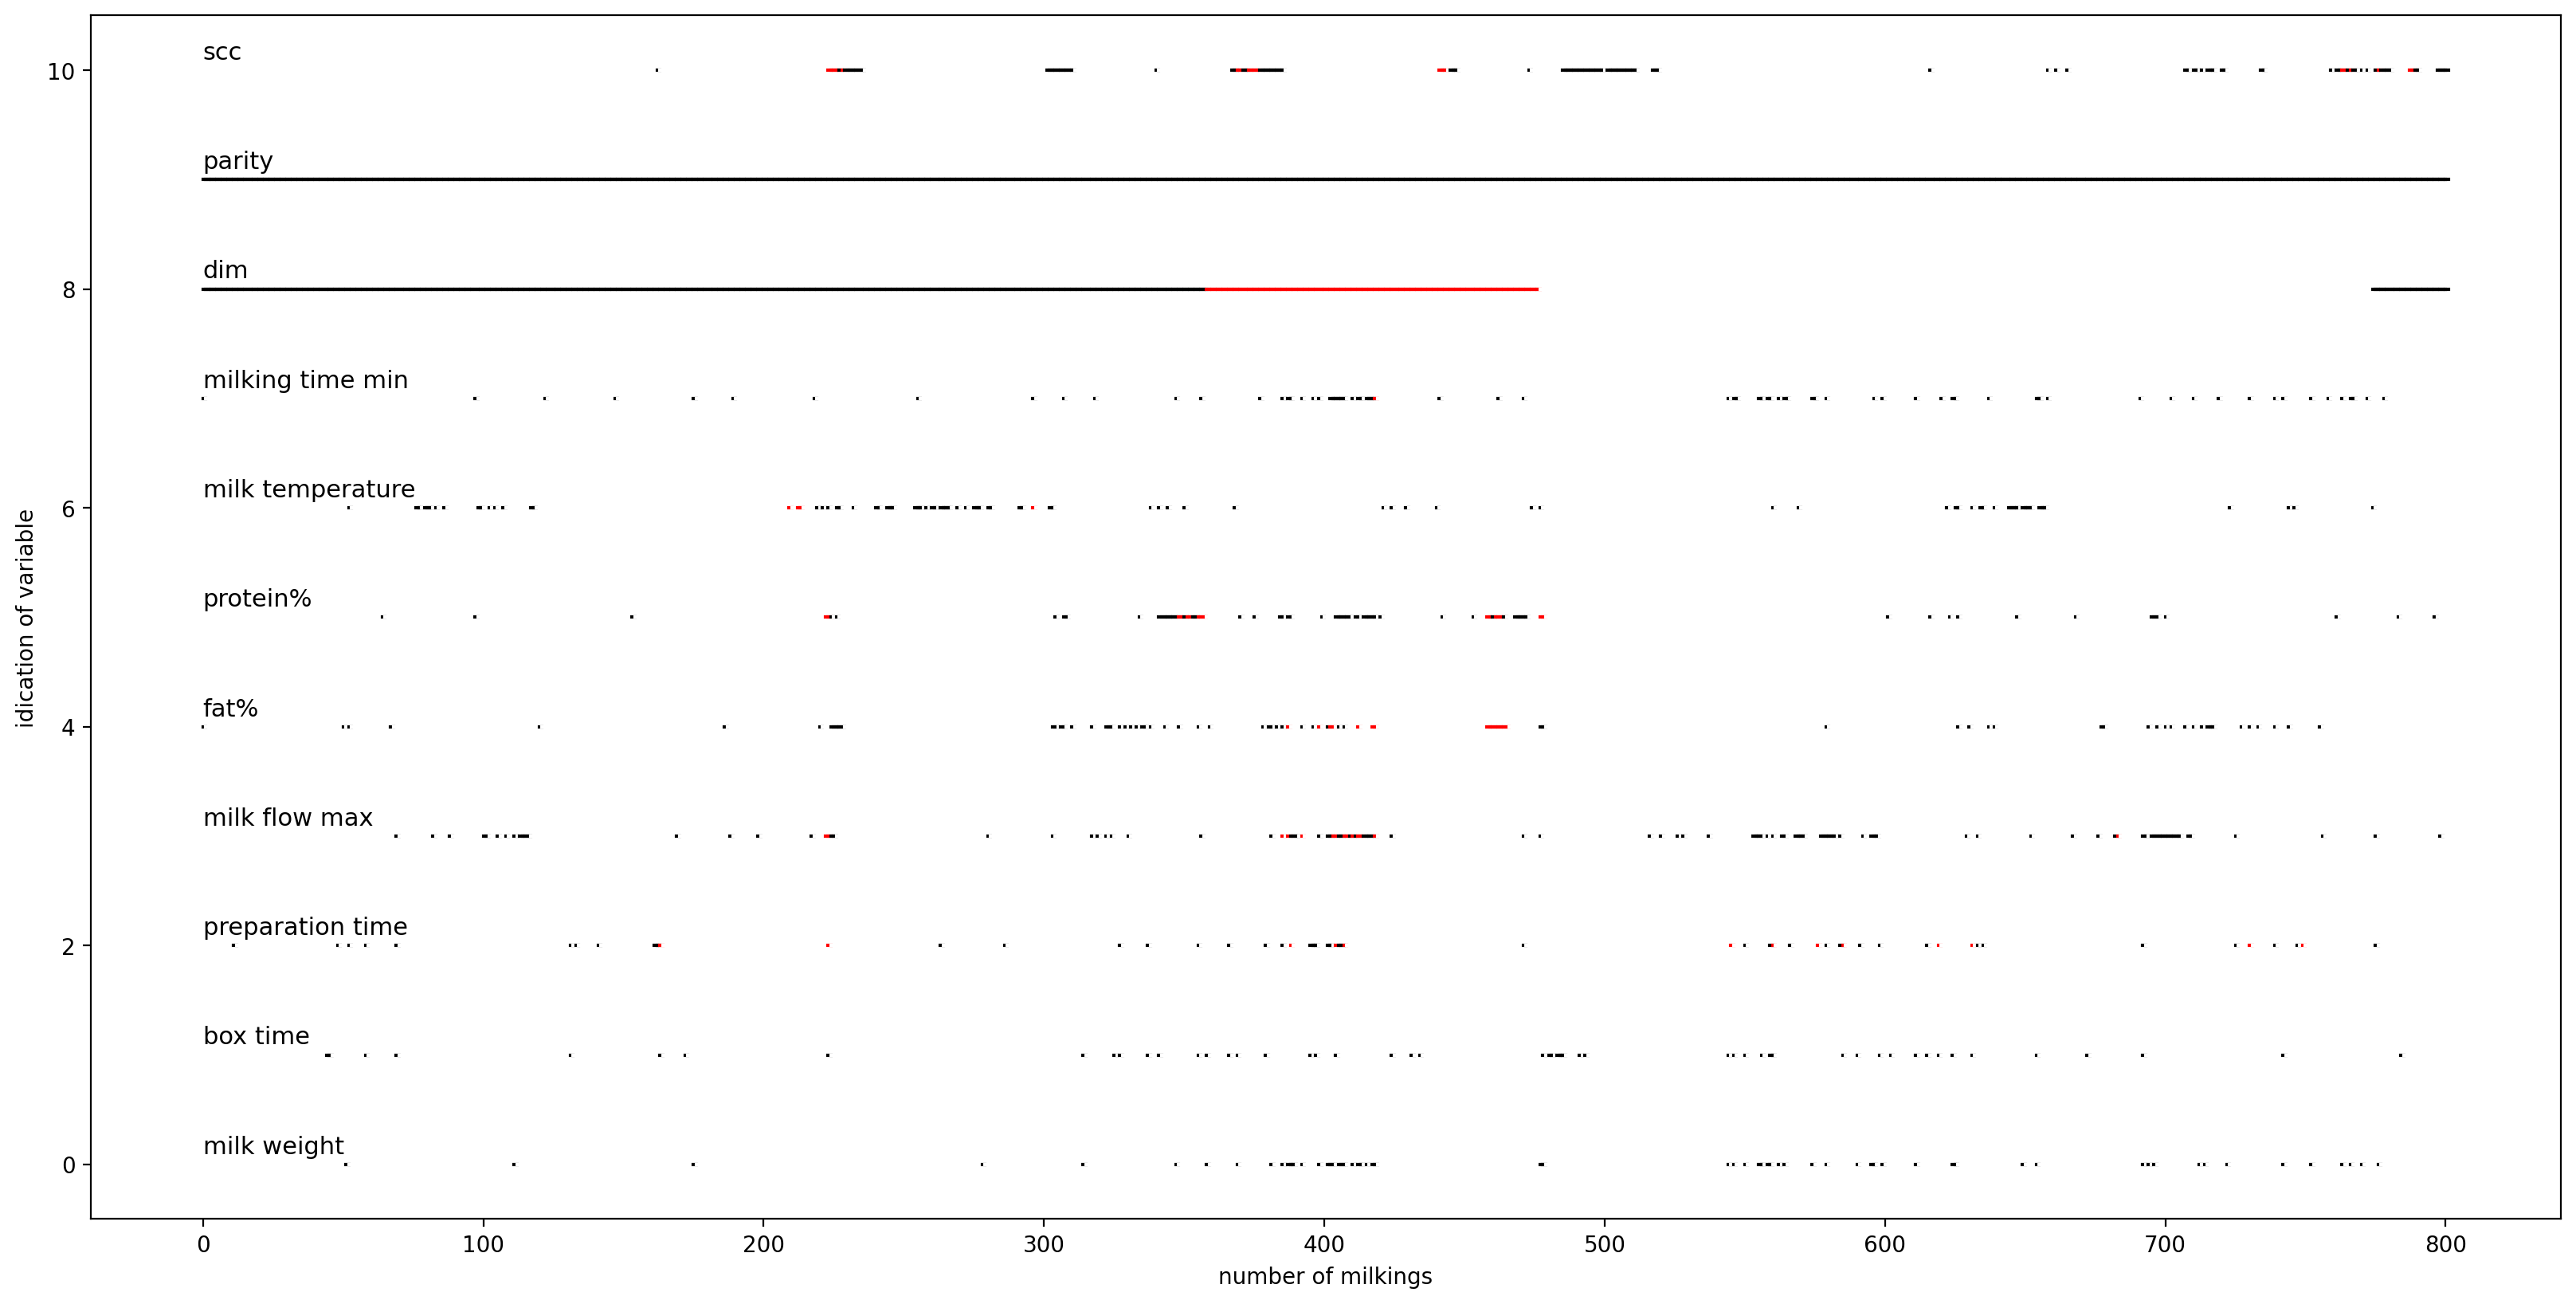

pick a random cow example:  229030
labels:  Index(['mk_wgt_cat', 'box_time_cat', 'prep_time_cat', 'milk_flow_max_cat', 'ft_pcnt_cat', 'pt_pcnt_cat', 'milkng_temp_cat', 'min_time_cat', 'dim_cat', 'parity_cat', 'scc_cat'], dtype='object')
confirm labels:  ['milk weight', 'box time', 'preparation time', 'milk flow max', 'fat%', 'protein%', 'milk temperature', 'milking time min', 'dim', 'parity', 'scc']


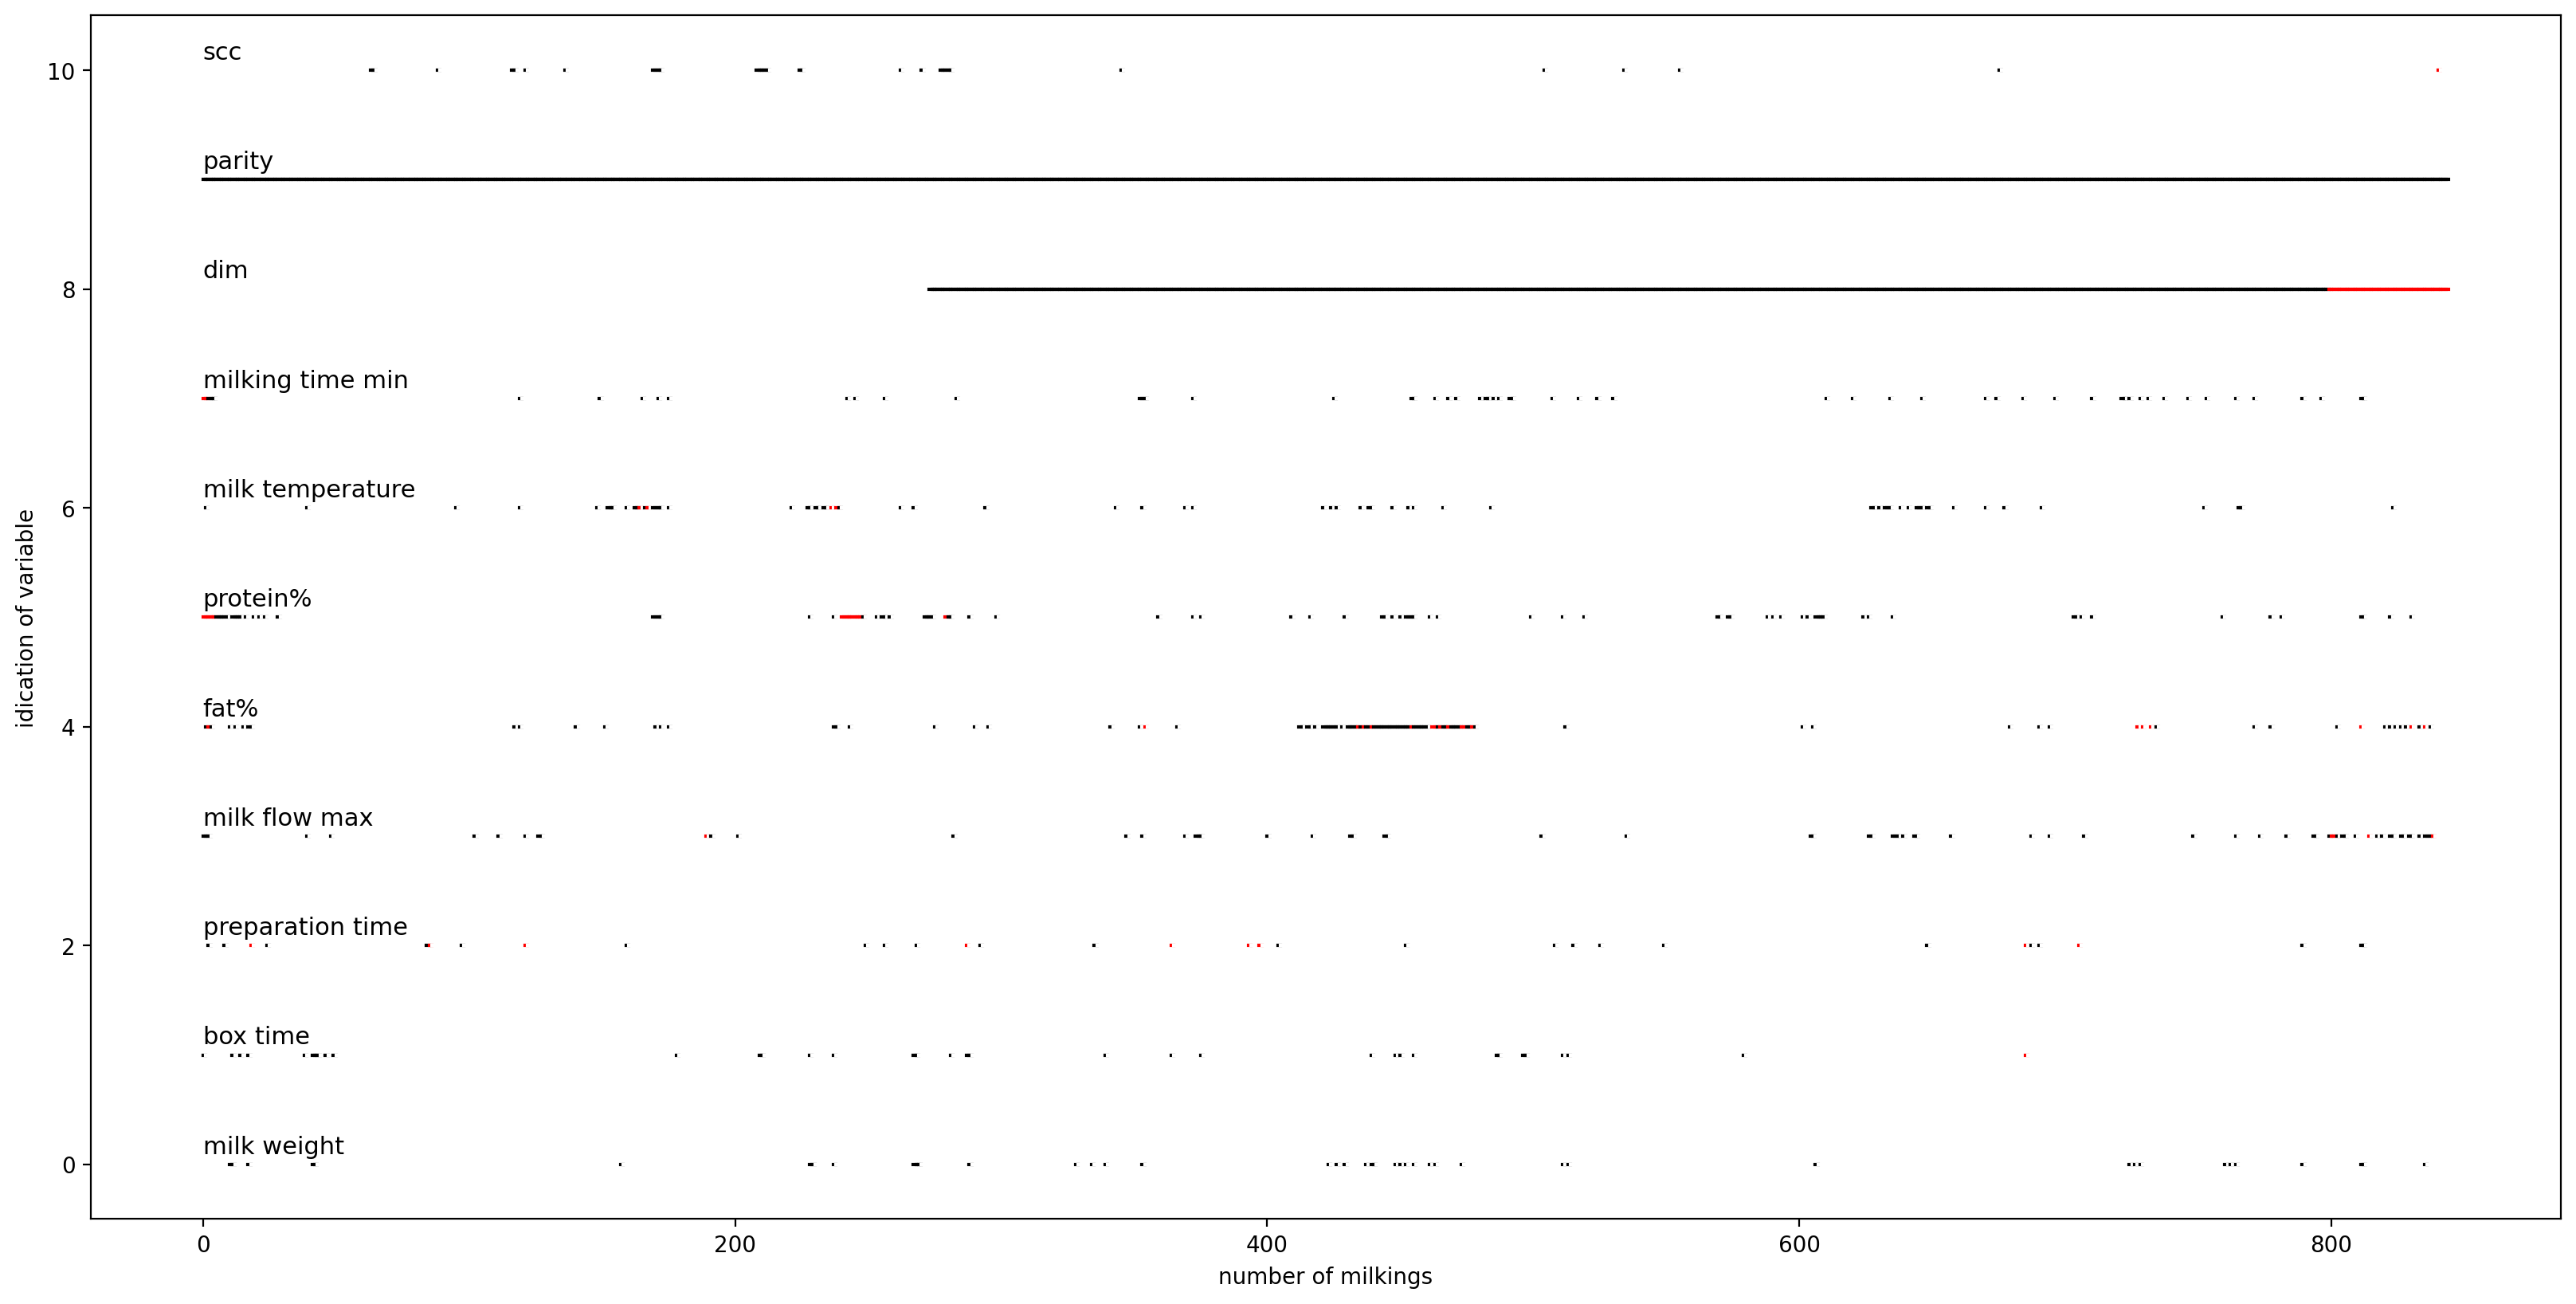

pick a random cow example:  387030
labels:  Index(['mk_wgt_cat', 'box_time_cat', 'prep_time_cat', 'milk_flow_max_cat', 'ft_pcnt_cat', 'pt_pcnt_cat', 'milkng_temp_cat', 'min_time_cat', 'dim_cat', 'parity_cat', 'scc_cat'], dtype='object')
confirm labels:  ['milk weight', 'box time', 'preparation time', 'milk flow max', 'fat%', 'protein%', 'milk temperature', 'milking time min', 'dim', 'parity', 'scc']


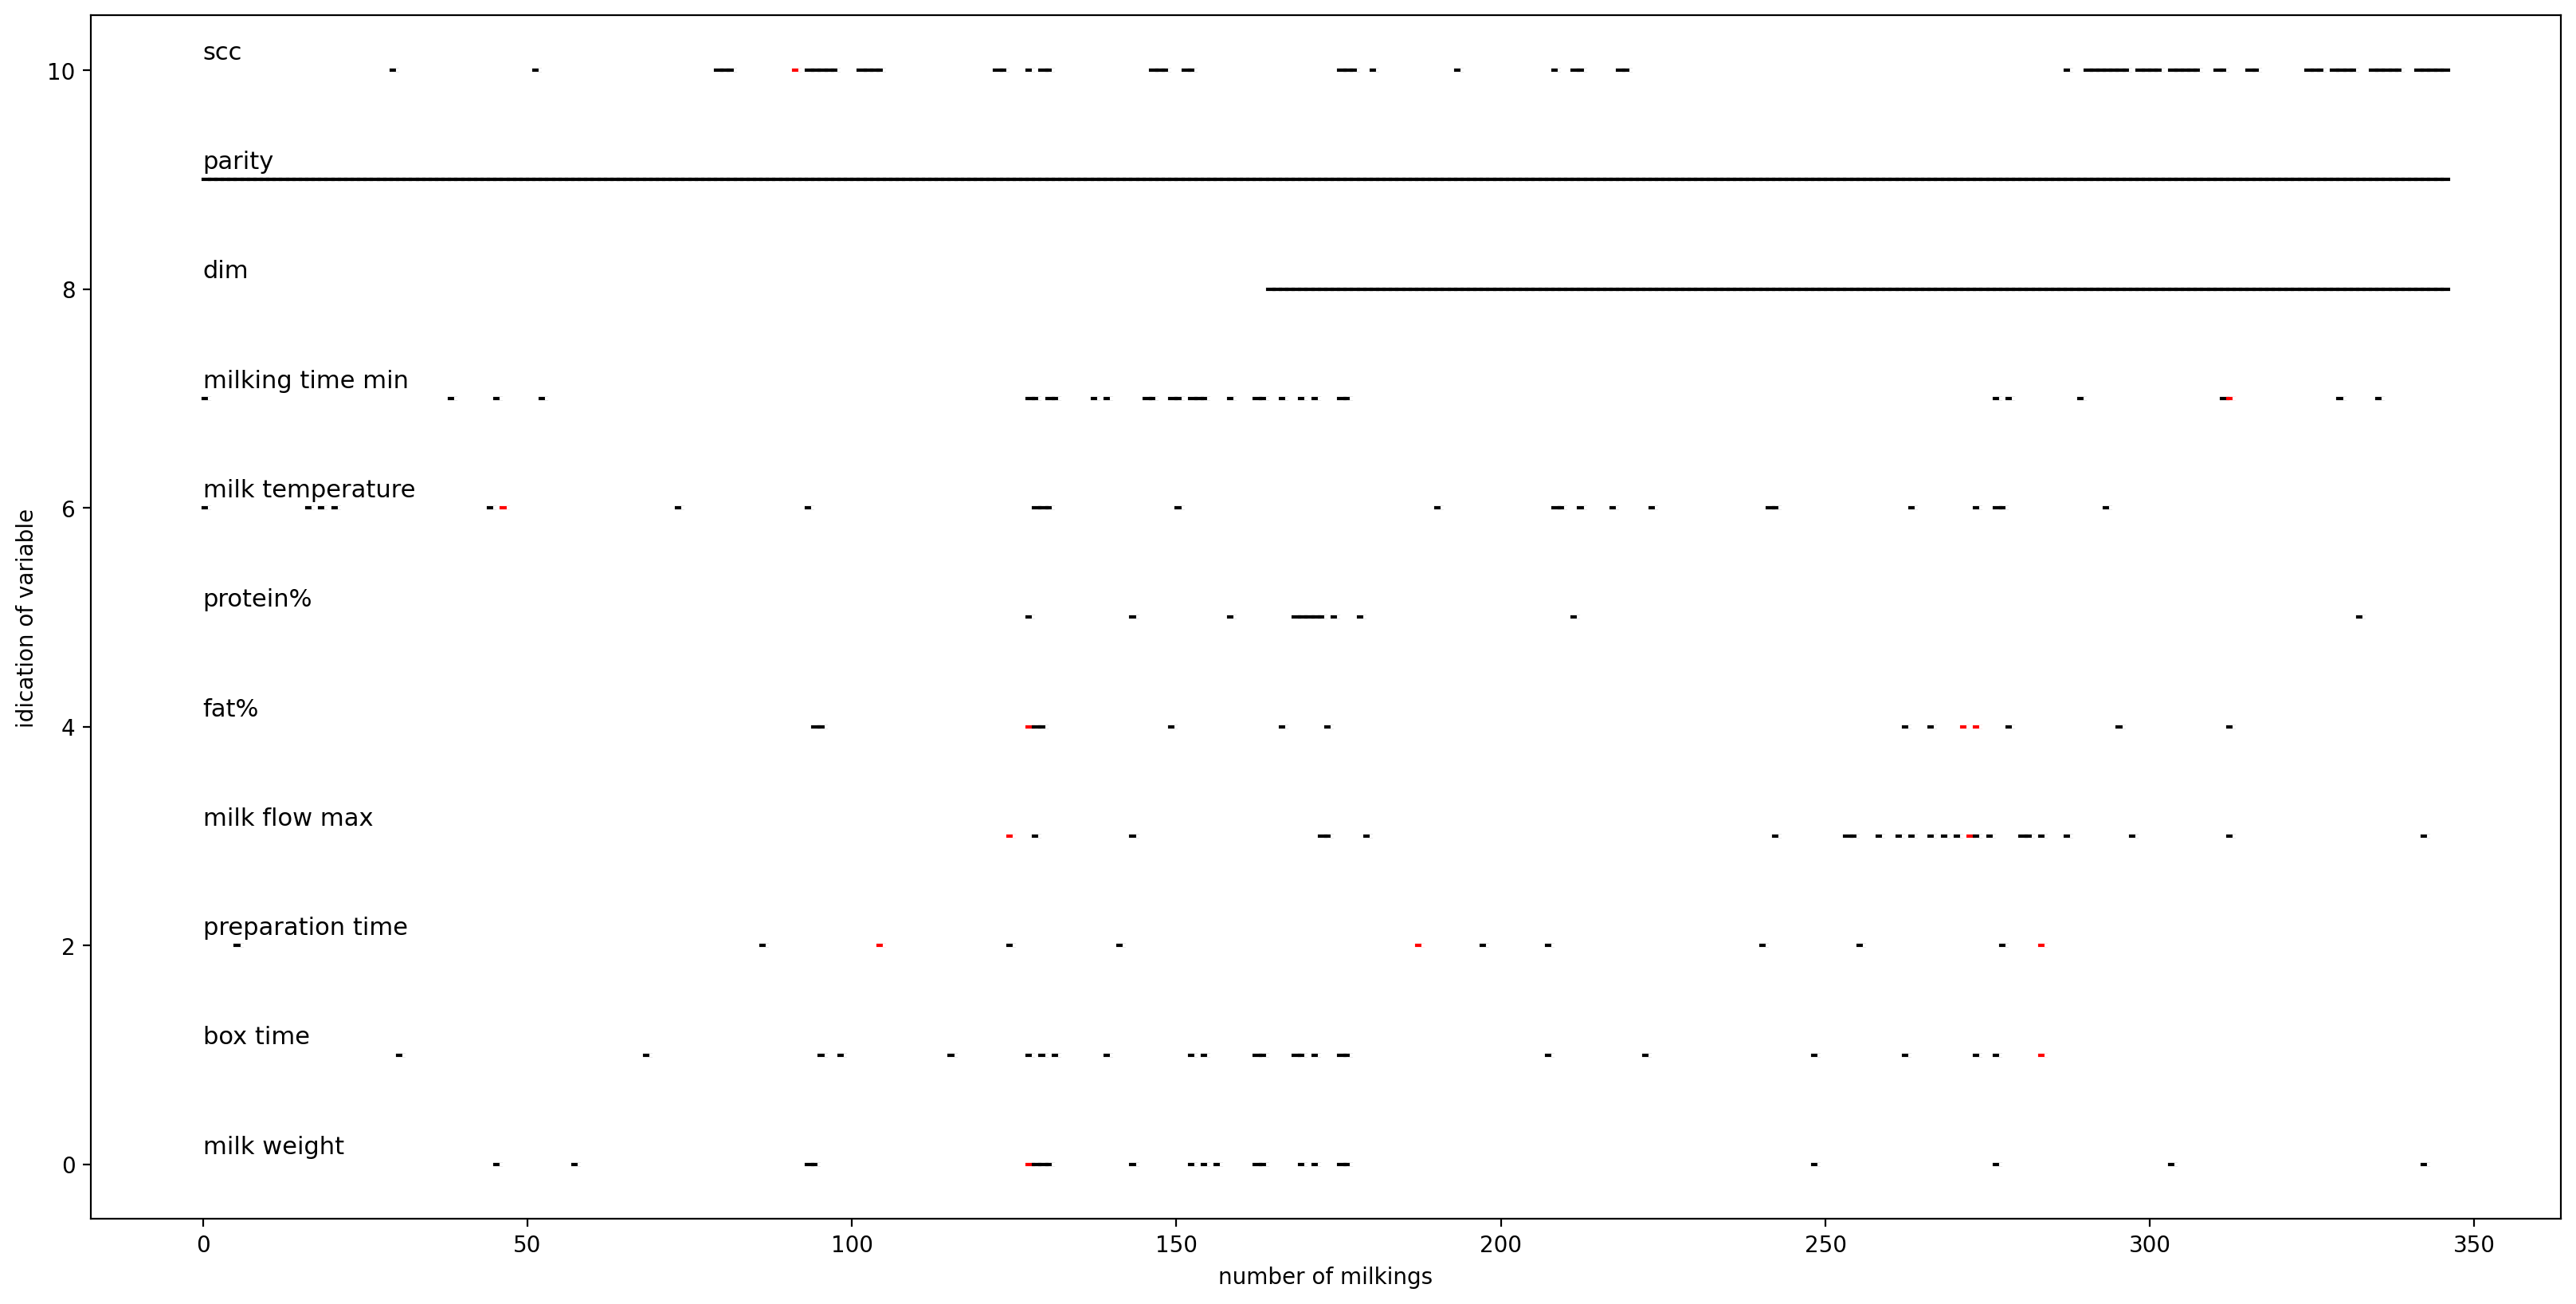

pick a random cow example:  755030
labels:  Index(['mk_wgt_cat', 'box_time_cat', 'prep_time_cat', 'milk_flow_max_cat', 'ft_pcnt_cat', 'pt_pcnt_cat', 'milkng_temp_cat', 'min_time_cat', 'dim_cat', 'parity_cat', 'scc_cat'], dtype='object')
confirm labels:  ['milk weight', 'box time', 'preparation time', 'milk flow max', 'fat%', 'protein%', 'milk temperature', 'milking time min', 'dim', 'parity', 'scc']


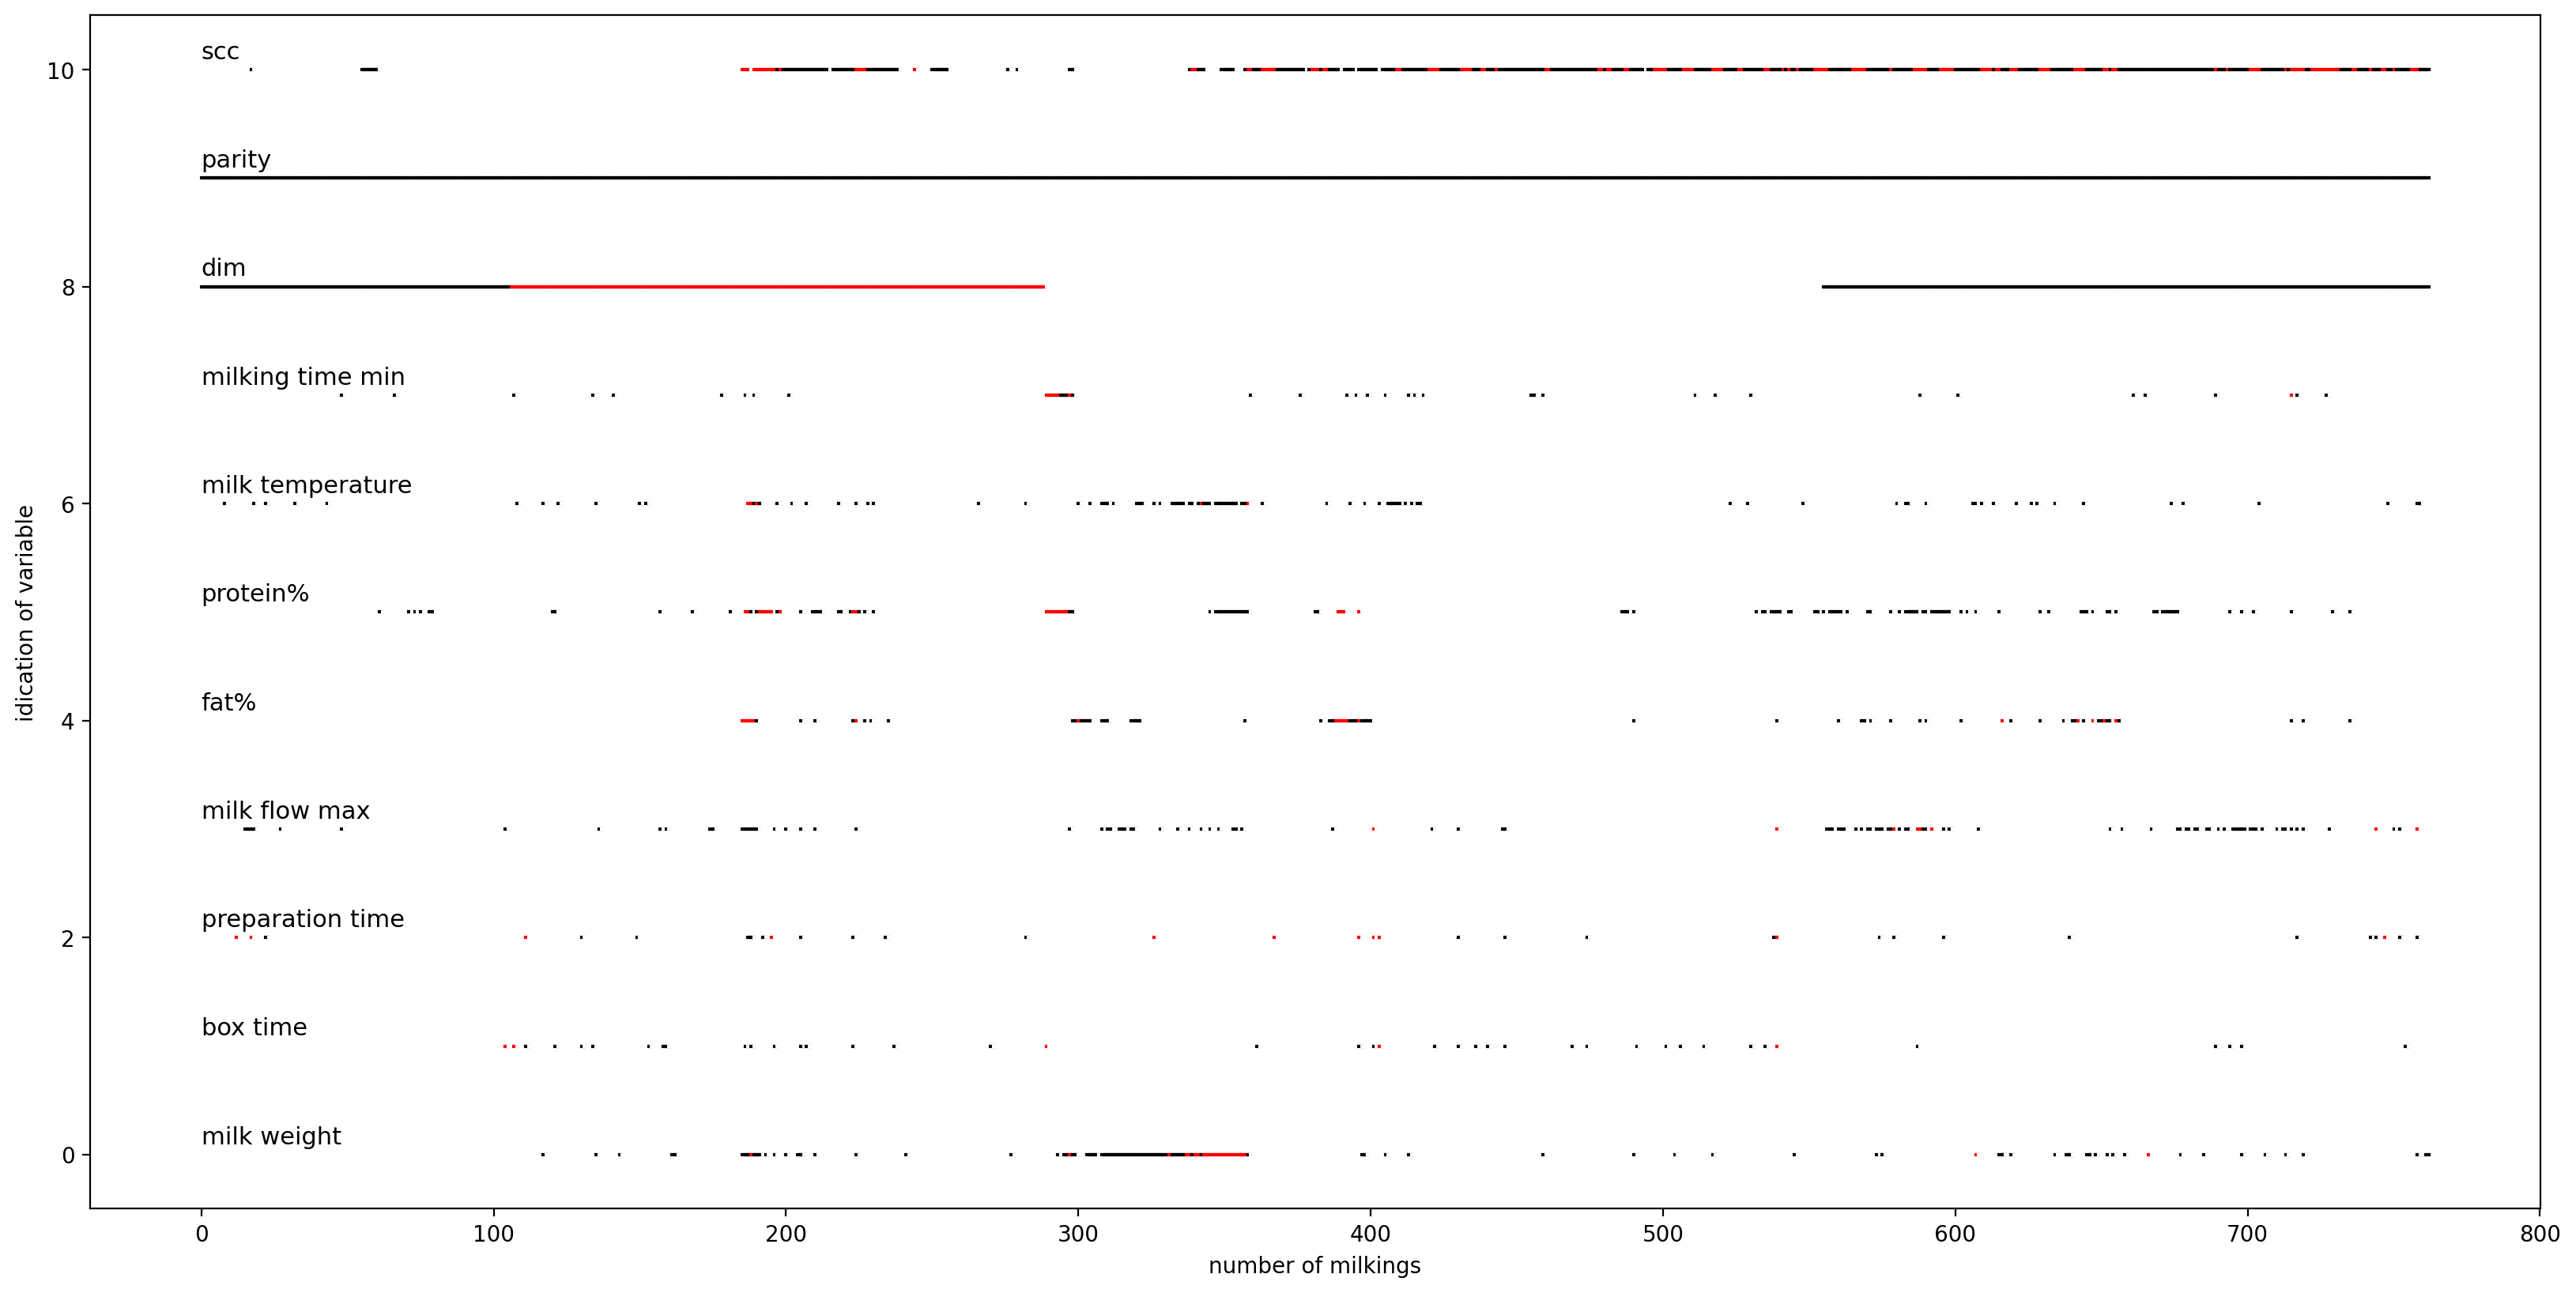

pick a random cow example:  81430
labels:  Index(['mk_wgt_cat', 'box_time_cat', 'prep_time_cat', 'milk_flow_max_cat', 'ft_pcnt_cat', 'pt_pcnt_cat', 'milkng_temp_cat', 'min_time_cat', 'dim_cat', 'parity_cat', 'scc_cat'], dtype='object')
confirm labels:  ['milk weight', 'box time', 'preparation time', 'milk flow max', 'fat%', 'protein%', 'milk temperature', 'milking time min', 'dim', 'parity', 'scc']


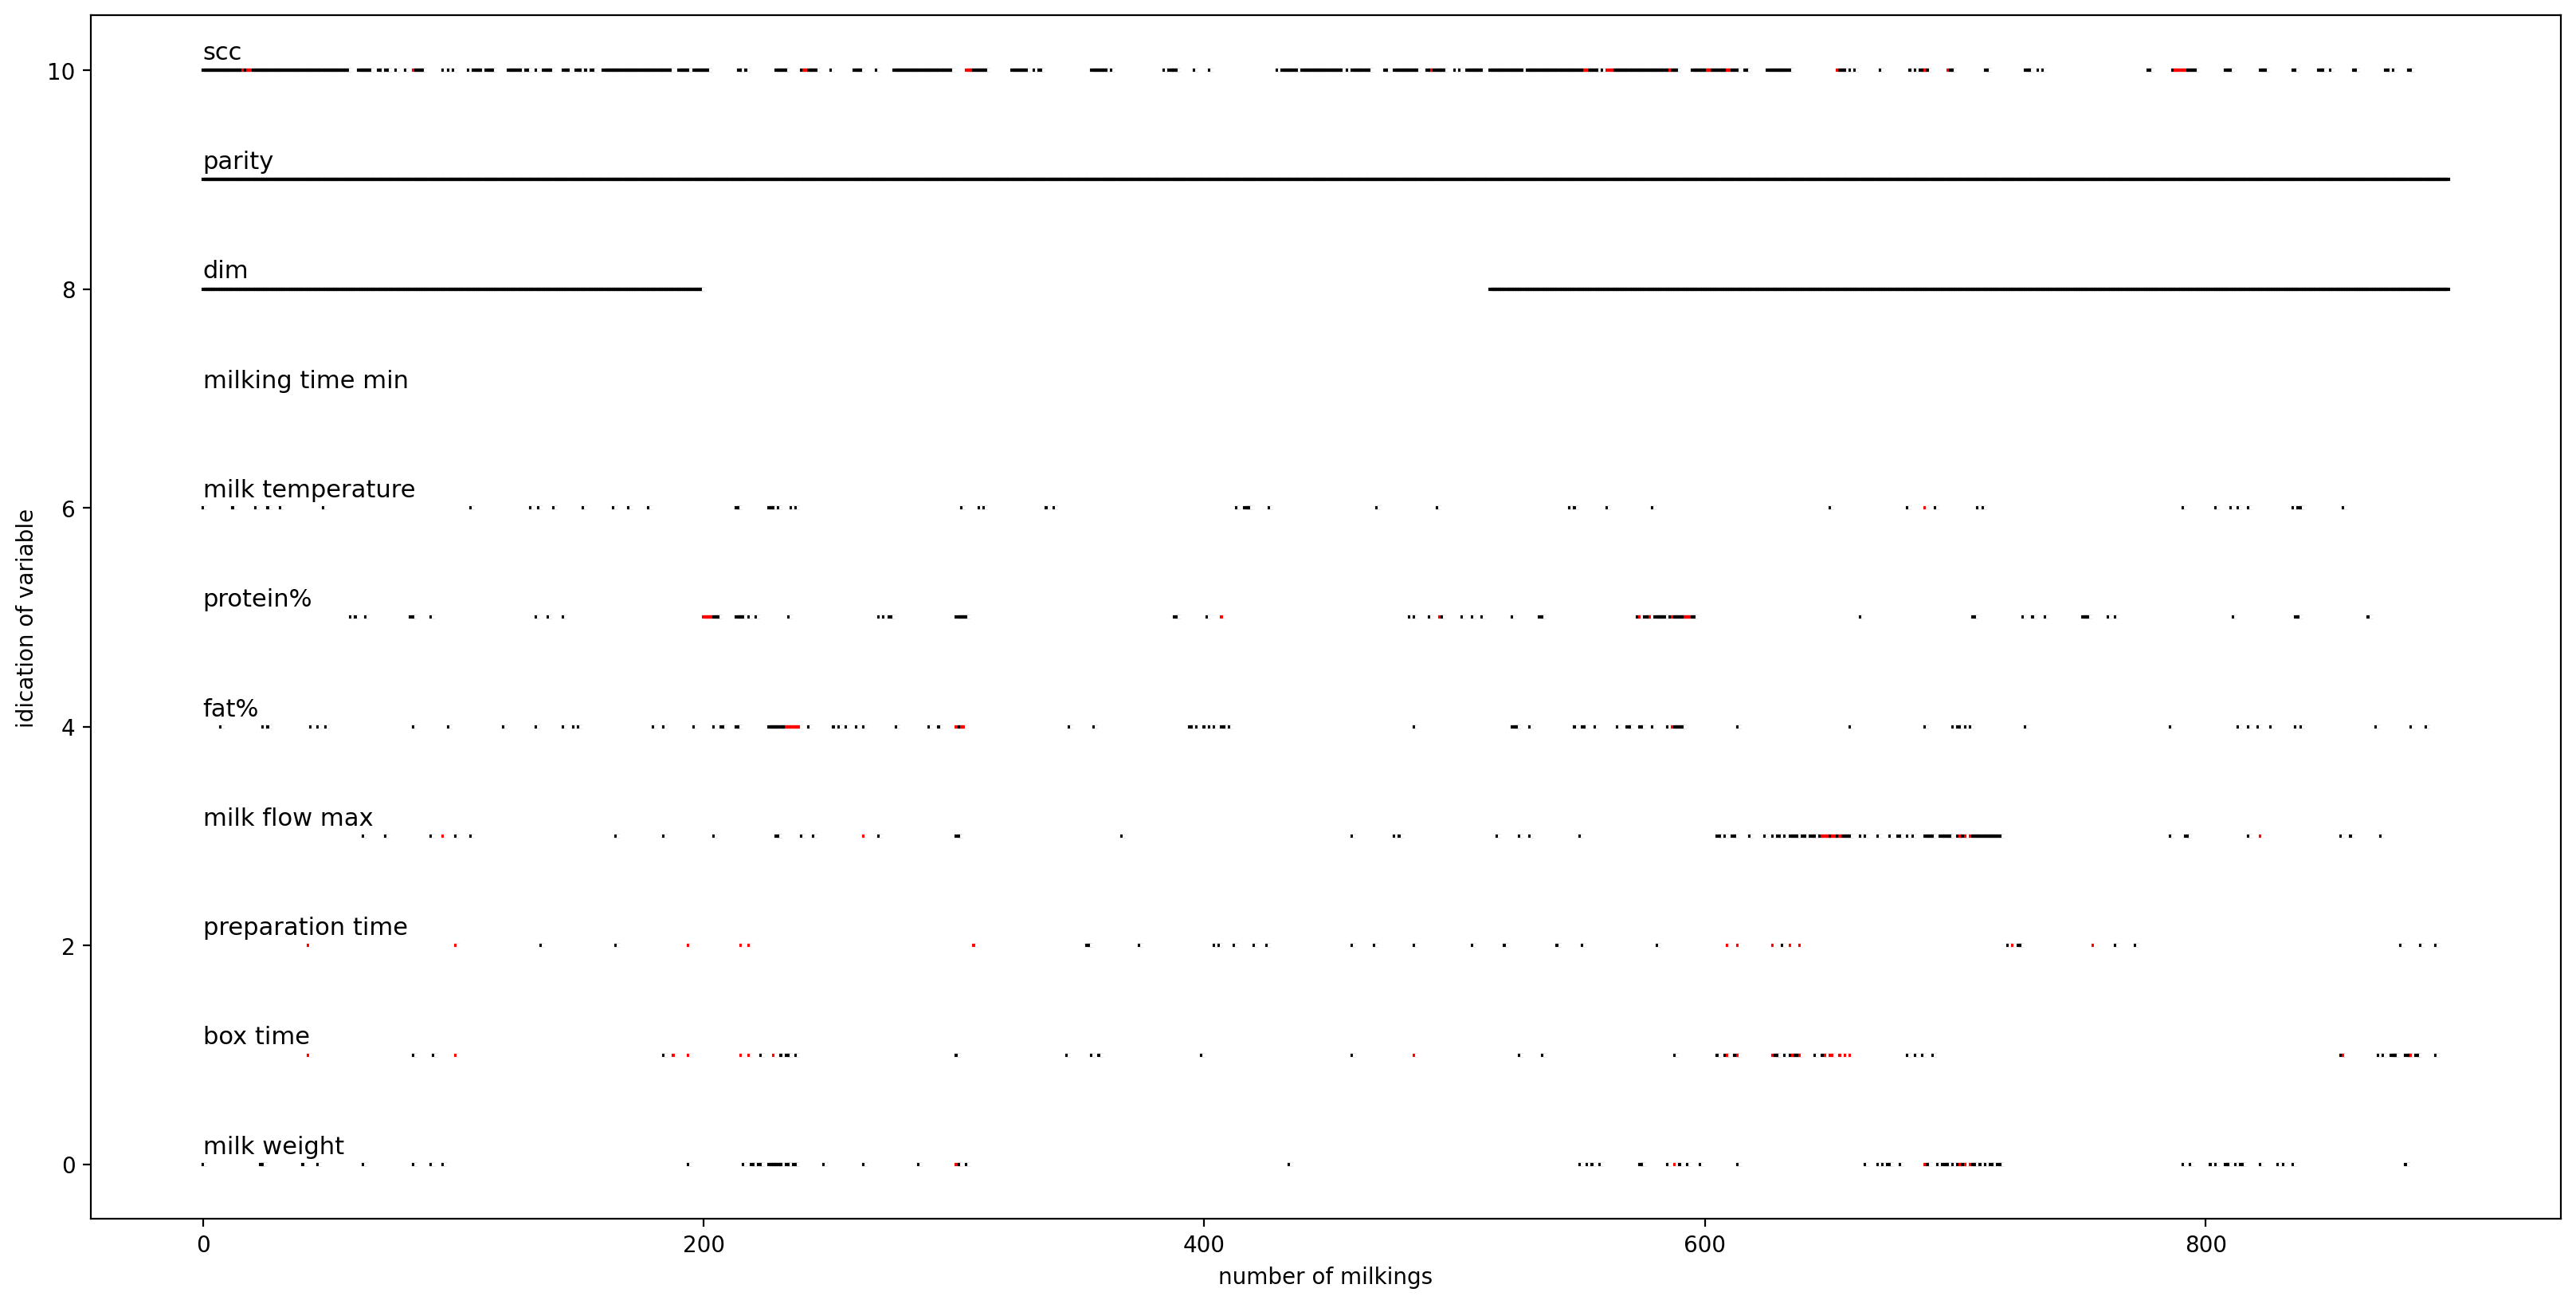

pick a random cow example:  570330
labels:  Index(['mk_wgt_cat', 'box_time_cat', 'prep_time_cat', 'milk_flow_max_cat', 'ft_pcnt_cat', 'pt_pcnt_cat', 'milkng_temp_cat', 'min_time_cat', 'dim_cat', 'parity_cat', 'scc_cat'], dtype='object')
confirm labels:  ['milk weight', 'box time', 'preparation time', 'milk flow max', 'fat%', 'protein%', 'milk temperature', 'milking time min', 'dim', 'parity', 'scc']


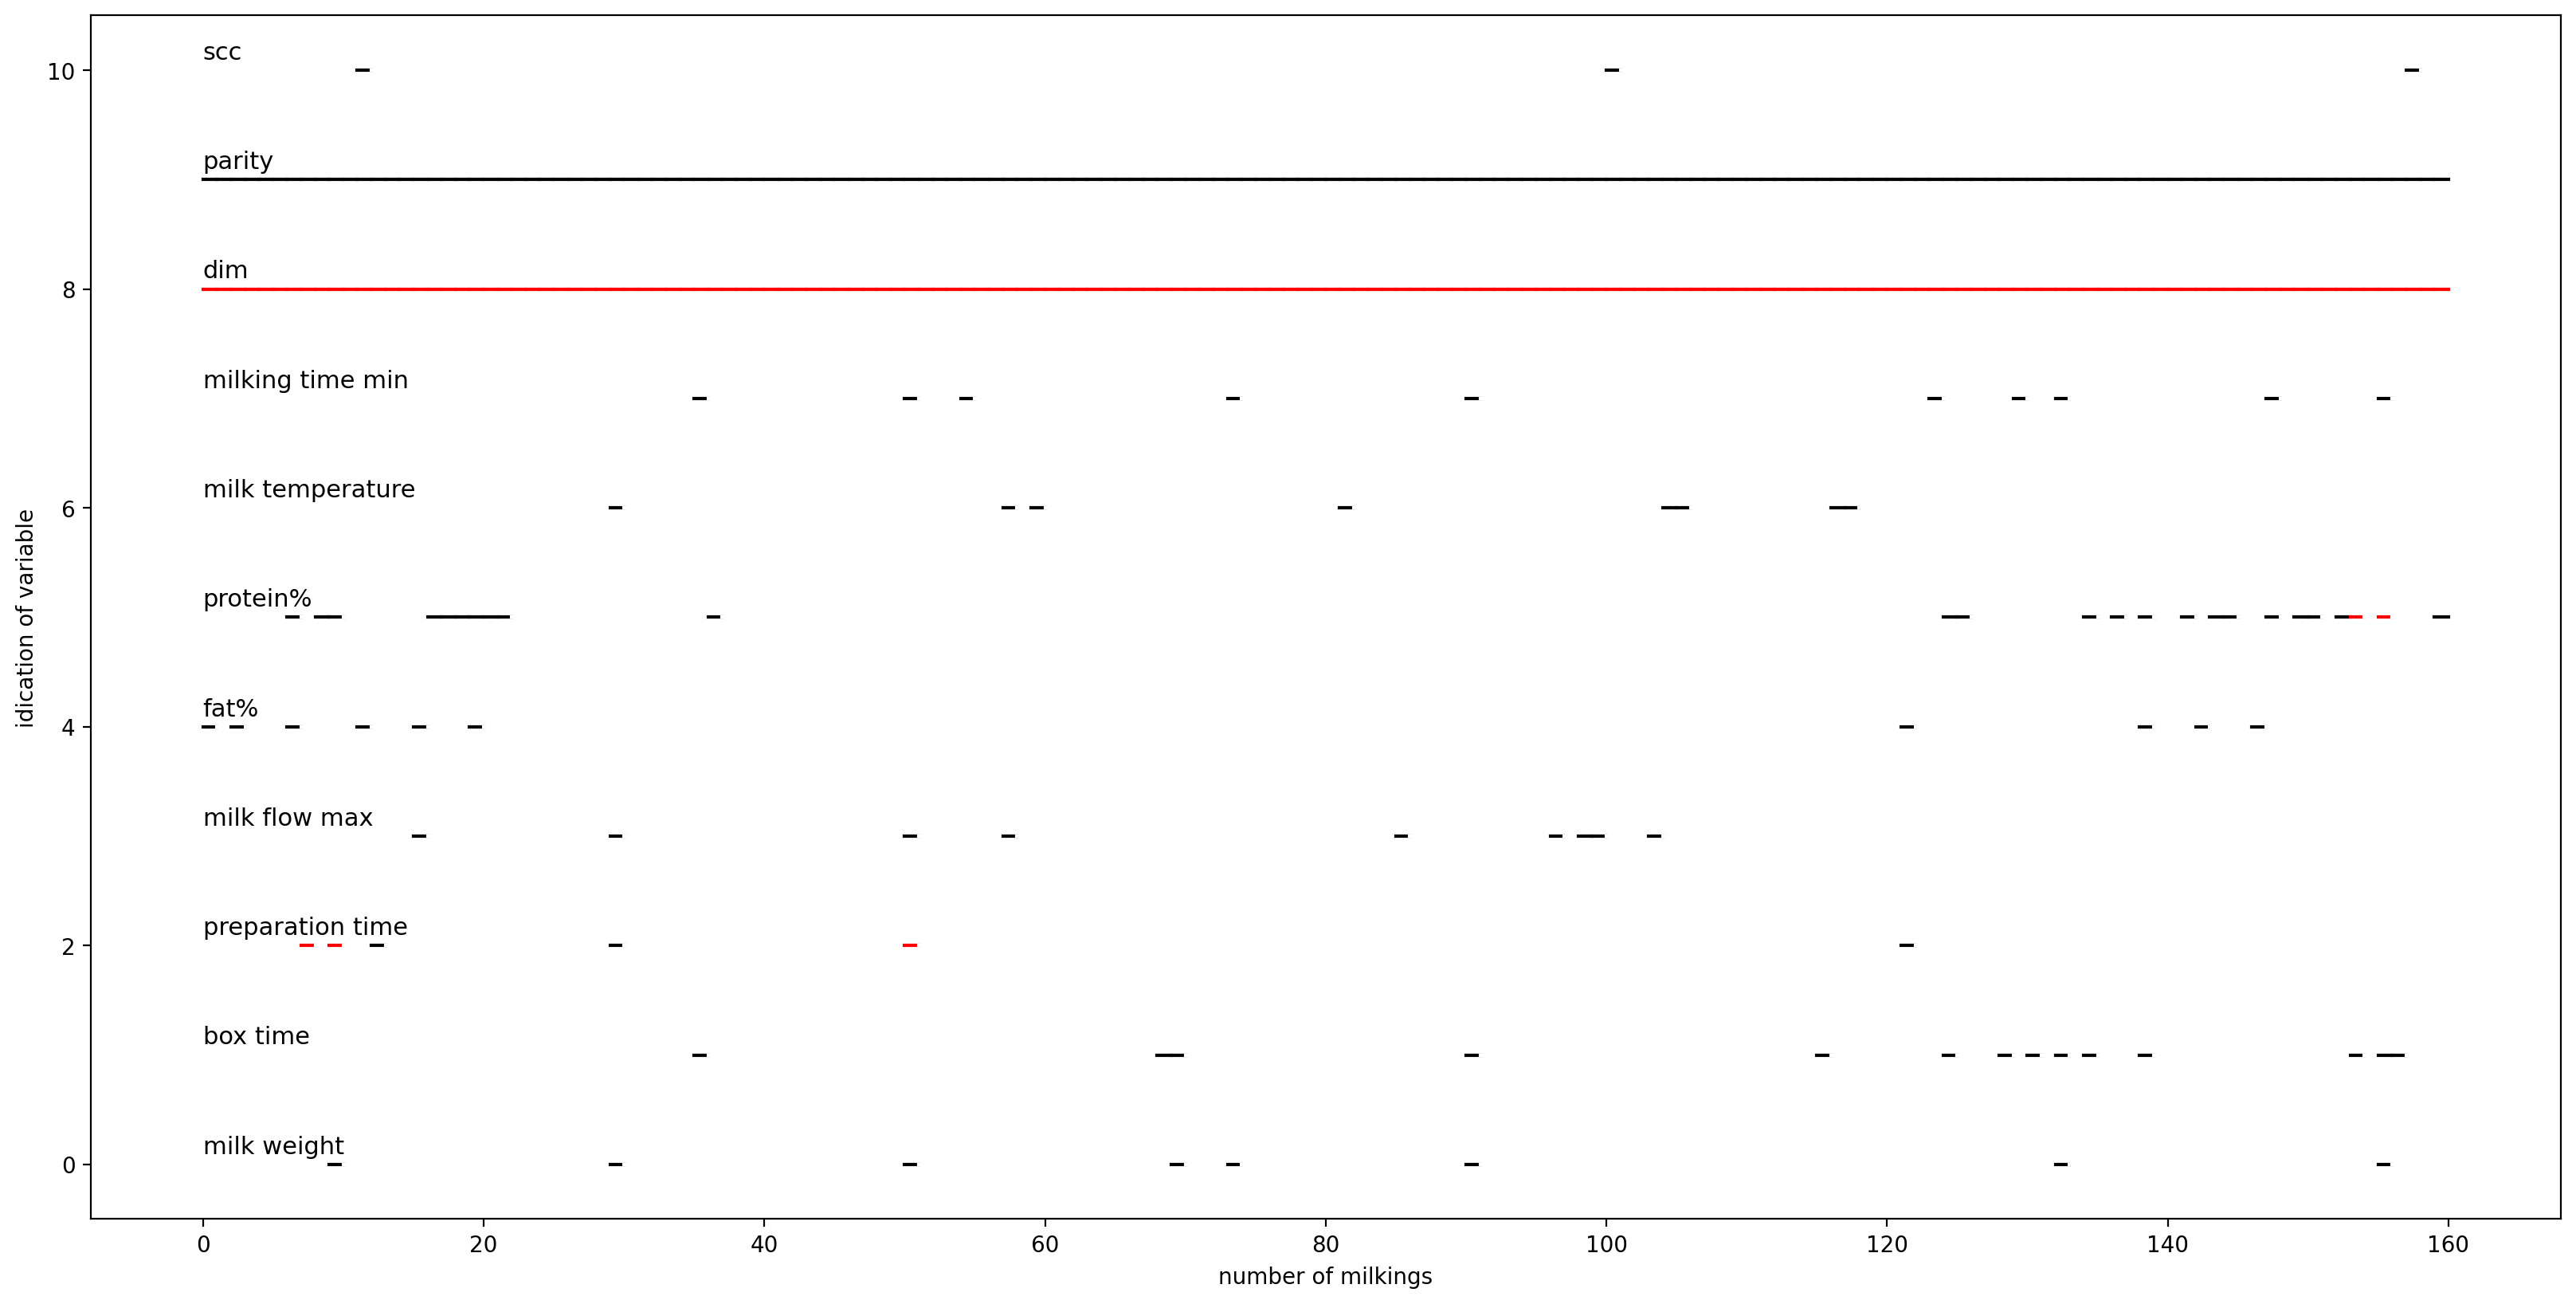

In [134]:
for choice_idx in range(10):
    from matplotlib.pyplot import figure
    figure(figsize=(20, 10), dpi=200)

    # pick a index
    cow_herd_id_ls = df_cat['cow_herd_id'].unique().tolist()
    pick_idx = choice_idx
    assert pick_idx < len(cow_herd_id_ls)
    cow_idx = cow_herd_id_ls[pick_idx]
    df_cow = df_cat[df_cat['cow_herd_id'] == cow_idx]
    print("pick a random cow example: ", cow_idx)

    # drop idx column as we are not plotting 
    df_cow = df_cow.drop(columns=['cow_herd_id'])
    # obtain labels 
    ls_columns = df_cow.columns
    print("labels: ", ls_columns)
    # reset label to be more readable 
    ls_columns = ['milk weight', 'box time', 'preparation time', 'milk flow max', 'fat%', 'protein%', 'milk temperature', 'milking time min', 'dim', 'parity', 'scc']
    print("confirm labels: ", ls_columns)

    # change df to np 
    np_cow = df_cow.to_numpy()

    # transpose np, required by one_line function
    mat = np_cow.T
    #print("mat: ", mat) 

    # loop to use one_line function
    for i in range(mat.shape[0]): 
        # print("we have the base and list: ", i, mat[i, :])
        """using func """
        one_line(mat[i, :], i)

    # add the string 
    for i in range(len(ls_columns)):
        plt.text(0, i+0.1, ls_columns[i], fontsize = 11)

    # show figure
    plt.ylabel("idication of variable")
    plt.xlabel("number of milkings")
    plt.show()